In [1]:
import json
import os

from analysis import *
from plot_main import *

plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams.update({'font.size': 20})
plt.rcParams['image.interpolation']='nearest'


### Load model and run simulation on experimental reward schedule and stimuli

In [2]:
exp_dir = '/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN/exp/dual_hierarchical_good_based_larger_noise/'
os.chdir('/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN')
# os.chdir('/Volumes/f005d7d/attn-rnn/Attn-WM-RNN')
# exp_dir = 'exp/dual_hierarchical_good_based_2_area_no_choice_to_area_1'

f = open(os.path.join(exp_dir, 'args.json'), 'r')
args = json.load(f)
print('loaded args')
# load model
ITI = 0.25
choice_start = 0.6
rwd_start = 0.75
stim_end = 0.9
mask_onset = 0.4
# experiment timeline [0.75 fixation, 2.5 stimulus, 0.5 action presentation, 1.0 reward presentation]
# 2021 paper          [0.5          , 0.7         , 0.3                    , 0.2                   ]
# here                [0.2          , 0.6         , 0.15                   , 0.15                  ]

exp_times = {
    'start_time': -ITI,
    'end_time': stim_end,
    'stim_onset': 0.0,
    'stim_end': stim_end,
    'mask_onset': mask_onset,
    'mask_end': choice_start,
    'choice_onset': choice_start,
    'choice_end': stim_end,
    'rwd_onset': rwd_start,
    'rwd_end': stim_end,
    'total_time': ITI+stim_end,
    'dt': args['dt']}
log_interval = 1
task_mdprl = MDPRL(exp_times, args['input_type'])
print('loaded task')


input_size = {
    'feat': args['stim_dim']*args['stim_val'],
    'feat+obj': args['stim_dim']*args['stim_val']+args['stim_val']**args['stim_dim'], 
    'feat+conj+obj': args['stim_dim']*args['stim_val']+args['stim_dim']*args['stim_val']*args['stim_val']+args['stim_val']**args['stim_dim'],
}[args['input_type']]

args['num_options'] = 2 if 'double' in args['task_type'] else 1

num_options = 1 if args['task_type']=='value' else 2
if args['decision_space']=='action':
    output_size = num_options
elif args['decision_space']=='good':
    output_size = args['stim_val']**args['stim_dim']
else:
    raise ValueError('Invalid decision space')
args['output_size'] = output_size


model_specs = {'input_size': input_size, 'hidden_size': args['hidden_size'], 'output_size': output_size, 'num_options': num_options,
                'plastic': args['plas_type']=='all', 'activation': args['activ_func'],
                'dt': args['dt'], 'tau_x': args['tau_x'], 'tau_w': args['tau_w'], 
                'e_prop': args['e_prop'], 'init_spectral': args['init_spectral'], 'balance_ei': args['balance_ei'],
                'sigma_rec': args['sigma_rec'], 'sigma_in': args['sigma_in'], 'sigma_w': args['sigma_w'], 
                'rwd_input': args.get('rwd_input', False), 'action_input': args['action_input'], 
                'sep_lr': args['sep_lr'], 'num_choices': 2 if 'double' in args['task_type'] else 1,
                'structured_conn': args['structured_conn'], 'num_areas': args['num_areas'],
                'inter_regional_sparsity': (1, 1), 'inter_regional_gain': (0.5, 0.5), 'input_plastic': not args['input_plas_off']}

E_SIZE = round(args['hidden_size']*args['e_prop'])
I_SIZE = round(args['hidden_size']*(1-args['e_prop']))
NUM_AREAS = args['num_areas']

model = HierarchicalRNN(**model_specs)
print(model)
for n, p in model.named_parameters():
    print(n, p.numel())

state_dict = torch.load(os.path.join(exp_dir, 'checkpoint.pth.tar'), map_location=torch.device('cpu'))['model_state_dict']
print(model.load_state_dict(state_dict))

loaded args
loaded task
HierarchicalRNN(
  (rnn): PlasticLeakyRNNCell(
    (x2h): EILinear()
    (aux2h): EILinear()
    (h2h): EILinear()
  )
  (h2o): EILinear()
)
rnn.kappa_rec 25600
rnn.x2h.weight 10080
rnn.aux2h.weight 4640
rnn.h2h.weight 25600
rnn.h2h.bias 160
h2o.weight 1728
<All keys matched successfully>


In [3]:
# run model

import pickle

test_activities_dir = '/dartfs-hpc/scratch/f005d7d/attn-rnn/test_activities'

if os.path.exists(test_activities_dir):
    print('found previous record pickle, loading previous results')
    with open(test_activities_dir, 'rb') as f:
        all_saved_states = pickle.load(f)
    print('loaded previous results')
else:
    all_saved_states = run_model(args, model, task_mdprl)
    print('simulation complete')
    with open(test_activities_dir, 'wb') as f:
        pickle.dump(all_saved_states, f)
    print(f'saved results to {test_activities_dir}')

found previous record pickle, loading previous results
loaded previous results


### Learning Curve

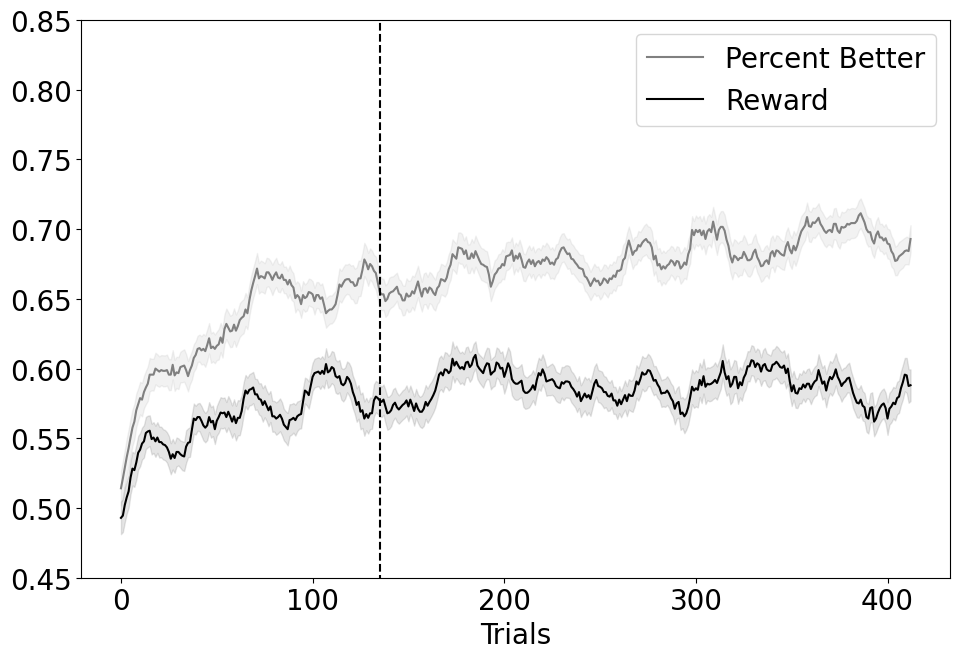

In [4]:
plot_learning_curve(args, all_saved_states['rewards'], all_saved_states['choose_better'])

Finished calculating norm of update
Finished calculating weight norms
Finished calculating variability


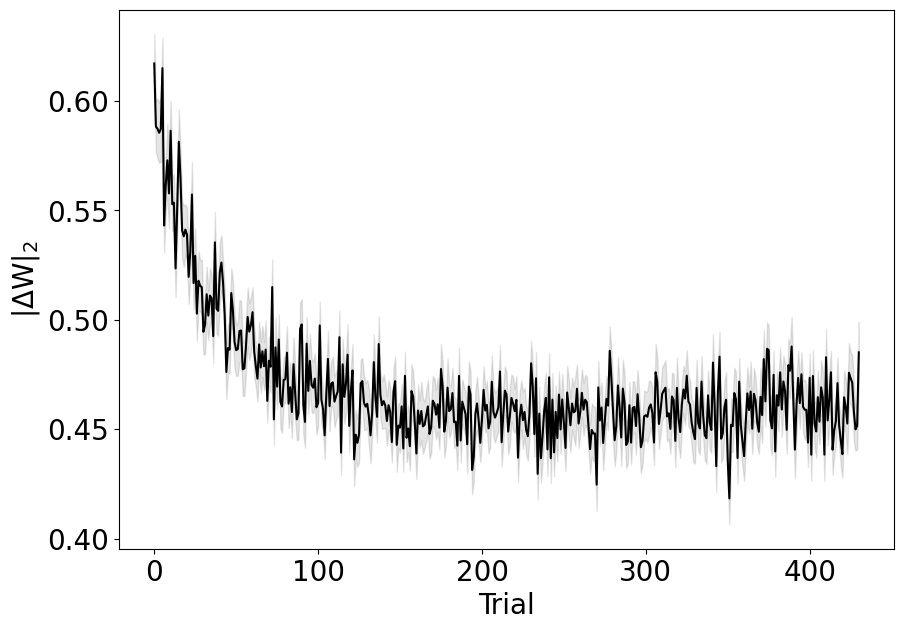

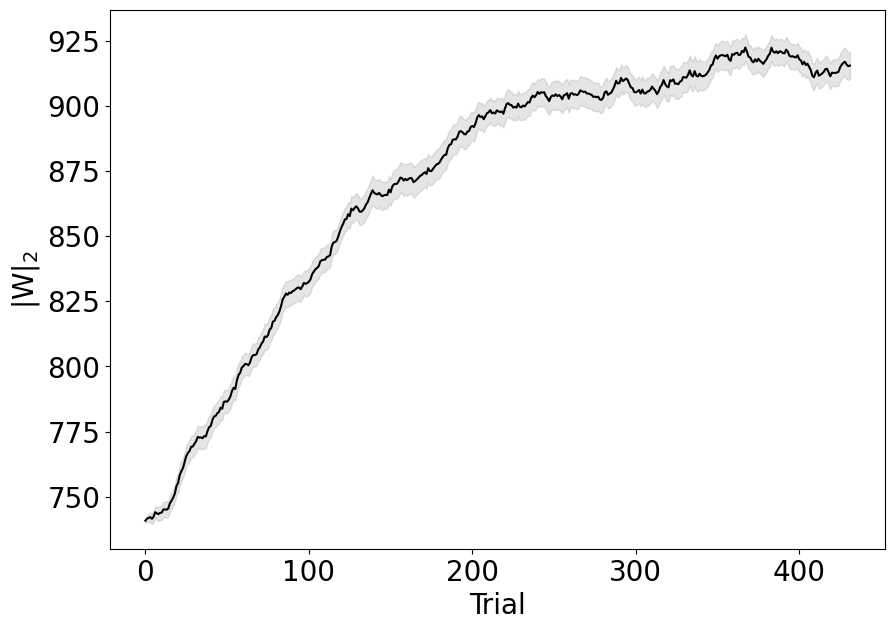

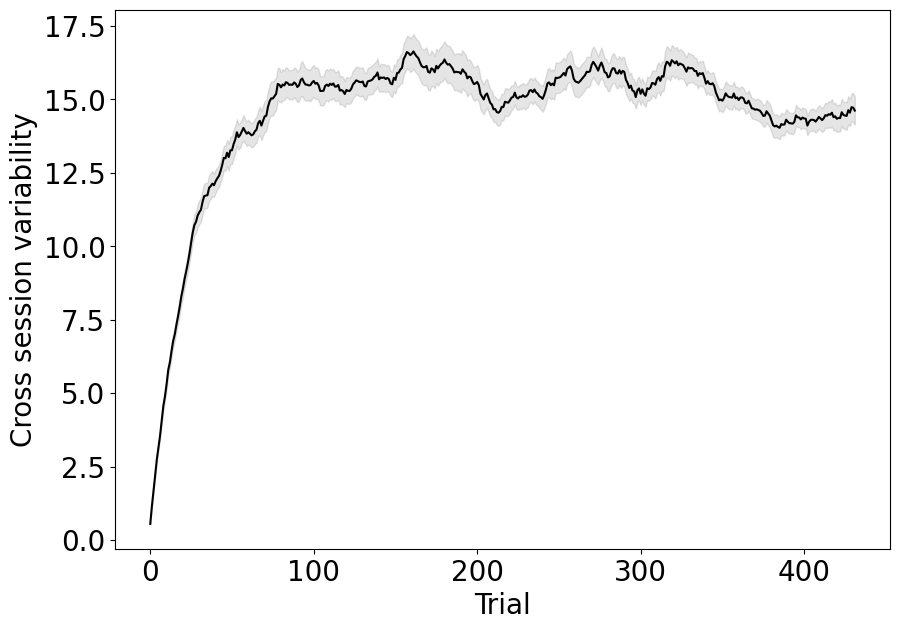

In [101]:
# all_saved_states['whs_final'].shape
plot_weight_summary(args, all_saved_states['whs_final'])

# Plot Initial Connectivity

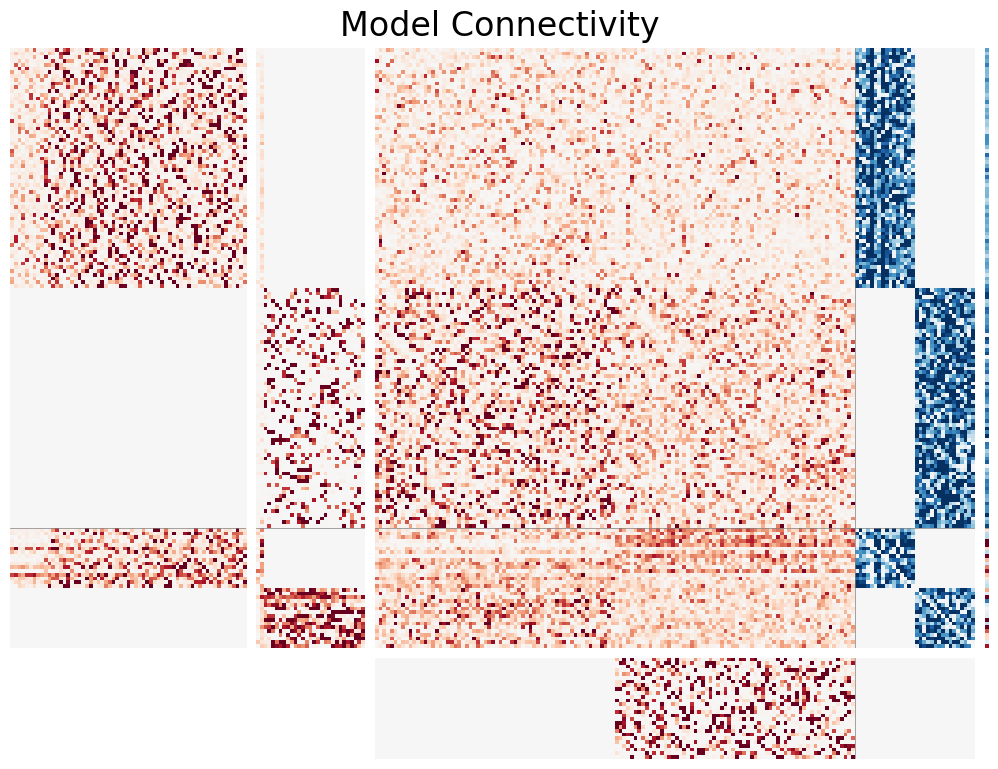

Figure saved at plots/exp/dual_hierarchical_good_based/connectivity.pdf


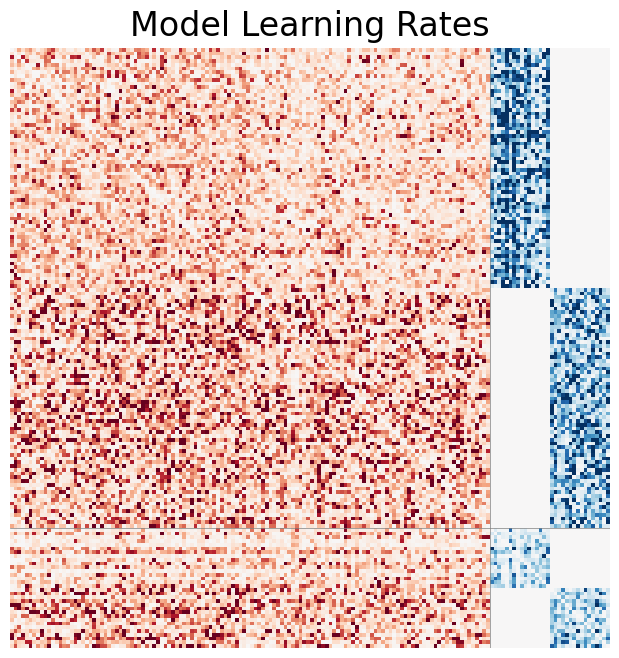

Figure saved at plots/exp/dual_hierarchical_good_based/learning_rates.pdf


In [18]:
plot_connectivity_lr(torch.arange(160), 
                             x2hw=model.rnn.x2h.effective_weight().detach(),
                             h2hw=model.rnn.h2h.effective_weight().detach(),
                             hb=state_dict['rnn.h2h.bias'].detach(),
                             h2ow=torch.cat([torch.zeros(27, 64), model.h2o.effective_weight().detach(), torch.zeros(27, 16*2)], dim=1),
                             aux2h=model.rnn.aux2h.effective_weight().detach(),
                             kappa_rec=model.rnn.kappa_rec.squeeze().abs().detach()*model.rnn.h2h.mask,
                             e_size=int(args['e_prop']*args['hidden_size'])*args['num_areas'], args=args)

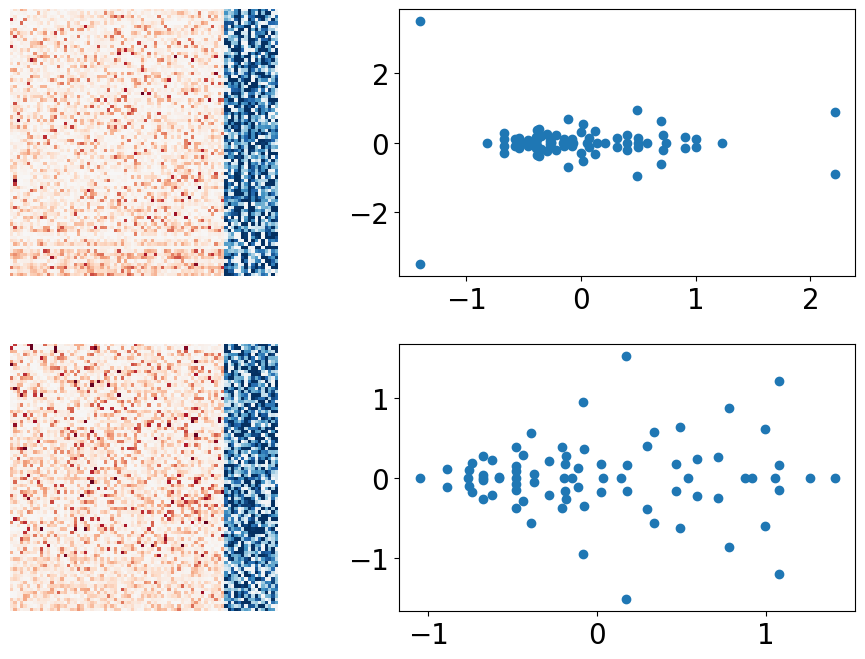

In [19]:
h2h = model.rnn.h2h.effective_weight().detach()

rec_intra = []
us = []
vhs = []
ss = []
for i in range(NUM_AREAS):
    rec_intra.append(h2h[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                         list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))]
                      [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                         list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
#     u, s, vh = np.linalg.svd(rec_intra[i], full_matrices=False)
    s = np.linalg.eigvals(rec_intra[i])
#     us.append(u)
#     vhs.append(vh)
    ss.append(s)
    
fig, axes = plt.subplots(NUM_AREAS, 2)
for i in range(NUM_AREAS):
    wlim = np.percentile(rec_intra[i].abs(), 95)
    axes[i,0].imshow(rec_intra[i], vmax=wlim, vmin=-wlim, cmap='RdBu_r', interpolation='nearest')
    axes[i,1].scatter(ss[i].real, ss[i].imag)
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    axes[i,0].axis('off')
#     axes[i,1].hlines(0.95, 0, 80, colors='grey', linestyles='dashed')
plt.tight_layout()
plt.show()

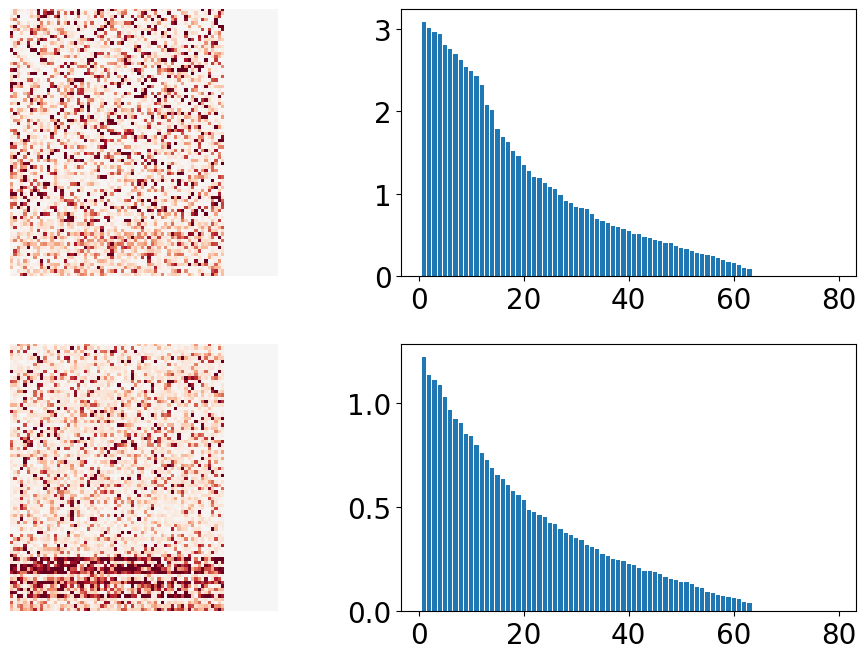

In [20]:
rec_inter_ff = []
rec_inter_fb = []
us_ff = []
us_fb = []
vhs_ff = []
vhs_fb = []
ss_ff = []
ss_fb = []
for i in range(NUM_AREAS-1):
   rec_inter_ff.append(h2h[list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                            list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))]
                         [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                            list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
   rec_inter_fb.append(h2h[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                            list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))]
                         [:,list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                            list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))])
   u, s, vh = np.linalg.svd(rec_inter_ff[i], full_matrices=False)
   us_ff.append(u)
   vhs_ff.append(vh)
   ss_ff.append(s)
   u, s, vh = np.linalg.svd(rec_inter_fb[i], full_matrices=False)
   us_fb.append(u)
   vhs_fb.append(vh)
   ss_fb.append(s)
   
    
fig, axes = plt.subplots(2,2)

for i in range(NUM_AREAS-1):
    wlim = np.percentile(rec_inter_ff[i], 95)
    axes[0,0].imshow(rec_inter_ff[i], vmin=-wlim, vmax=wlim, cmap='RdBu_r')
    axes[0,0].set_xticks([])
    axes[0,0].set_yticks([])
    axes[0,0].axis('off')
    axes[0,1].bar(np.arange(1,args['hidden_size']),ss_ff[i][1:])
#     axes[i,1].hlines(0.95, 0, 80, colors='grey', linestyles='dashed')
    wlim = np.percentile(rec_inter_fb[i], 95)
    axes[1,0].imshow(rec_inter_fb[i], vmin=-wlim, vmax=wlim, cmap='RdBu_r')
    axes[1,0].set_xticks([])
    axes[1,0].set_yticks([])
    axes[1,0].axis('off')
    axes[1,1].bar(np.arange(1,args['hidden_size']),ss_fb[i][1:])
#     axes[i,3].hlines(0.95, 0, 80, colors='grey', linestyles='dashed')
plt.tight_layout()
plt.show()

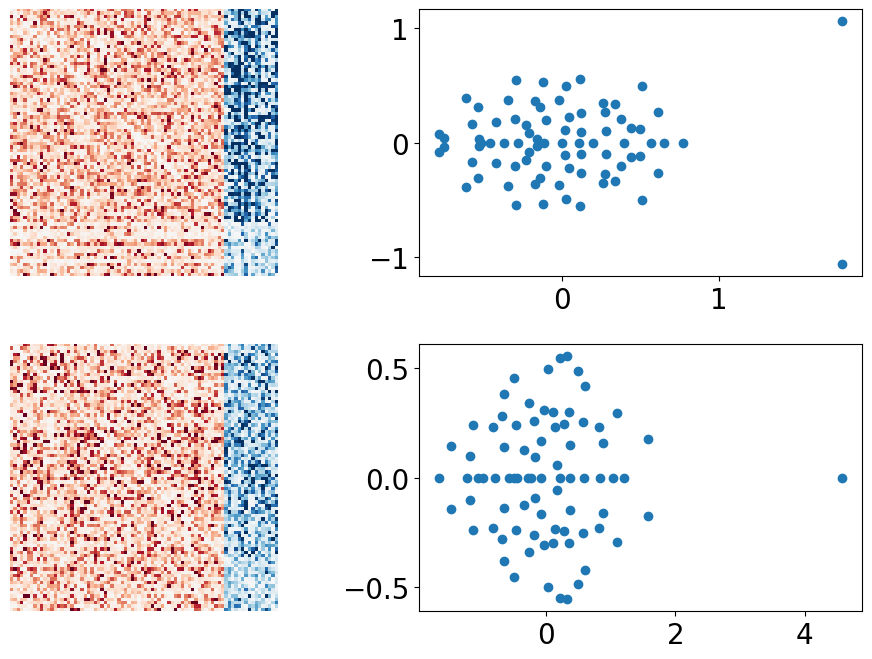

In [21]:
kappa_rec = model.rnn.kappa_rec.abs().detach()*model.rnn.h2h.mask

kappa_rec_intra = []
# us = []
# vhs = []
ss = []
for i in range(NUM_AREAS):
    kappa_rec_intra.append(kappa_rec[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                               list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))]
                              [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                 list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
#     u, s, vh = np.linalg.svd(kappa_rec_intra[i], full_matrices=False)
    s = np.linalg.eigvals(kappa_rec_intra[i])
#     us.append(u)
#     vhs.append(vh)
    ss.append(s)
    
fig, axes = plt.subplots(NUM_AREAS, 2)
for i in range(NUM_AREAS):
    wlim = np.percentile(kappa_rec_intra[i].abs(), 95)
    axes[i,0].imshow(kappa_rec_intra[i], vmax=wlim, vmin=-wlim, cmap='RdBu_r', interpolation='nearest')
    axes[i,1].scatter(ss[i].real, ss[i].imag)
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    axes[i,0].axis('off')
#     axes[i,1].hlines(0.95, 0, 80, colors='grey', linestyles='dashed')
plt.tight_layout()
plt.show()

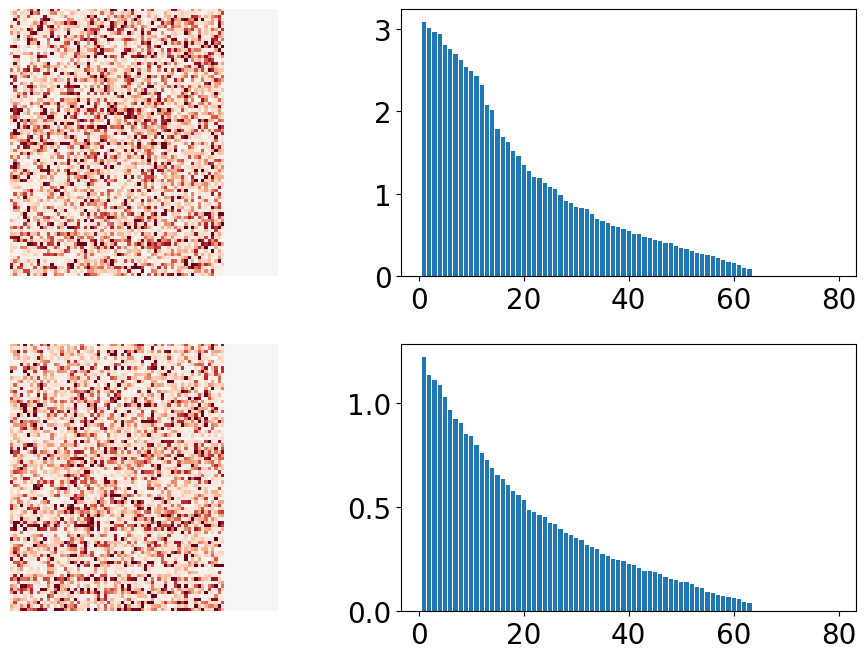

In [22]:
kappa_inter_ff = []
kappa_inter_fb = []
us_ff = []
us_fb = []
vhs_ff = []
vhs_fb = []
ss_ff = []
ss_fb = []
for i in range(NUM_AREAS-1):
   kappa_inter_ff.append(kappa_rec[list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                                 list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))]
                             [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
   kappa_inter_fb.append(kappa_rec[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                 list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))]
                                [:,list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                                   list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))])
   u, s, vh = np.linalg.svd(rec_inter_ff[i], full_matrices=False)
   us_ff.append(u)
   vhs_ff.append(vh)
   ss_ff.append(s)
   u, s, vh = np.linalg.svd(rec_inter_fb[i], full_matrices=False)
   us_fb.append(u)
   vhs_fb.append(vh)
   ss_fb.append(s)
   
    
fig, axes = plt.subplots(2,2)

for i in range(NUM_AREAS-1):
    wlim = np.percentile(kappa_inter_ff[i], 95)
    axes[0,0].imshow(kappa_inter_ff[i], vmin=-wlim, vmax=wlim, cmap='RdBu_r')
    axes[0,0].set_xticks([])
    axes[0,0].set_yticks([])
    axes[0,0].axis('off')
    axes[0,1].bar(np.arange(1,args['hidden_size']), ss_ff[i][1:])
#     axes[i,1].hlines(0.95, 0, 80, colors='grey', linestyles='dashed')
    wlim = np.percentile(kappa_inter_fb[i], 95)
    axes[1,0].imshow(kappa_inter_fb[i], vmin=-wlim, vmax=wlim, cmap='RdBu_r')
    axes[1,0].set_xticks([])
    axes[1,0].set_yticks([])
    axes[1,0].axis('off')
    axes[1,1].bar(np.arange(1,args['hidden_size']), ss_fb[i][1:])
#     axes[i,3].hlines(0.95, 0, 80, colors='grey', linestyles='dashed')
plt.tight_layout()
plt.show()

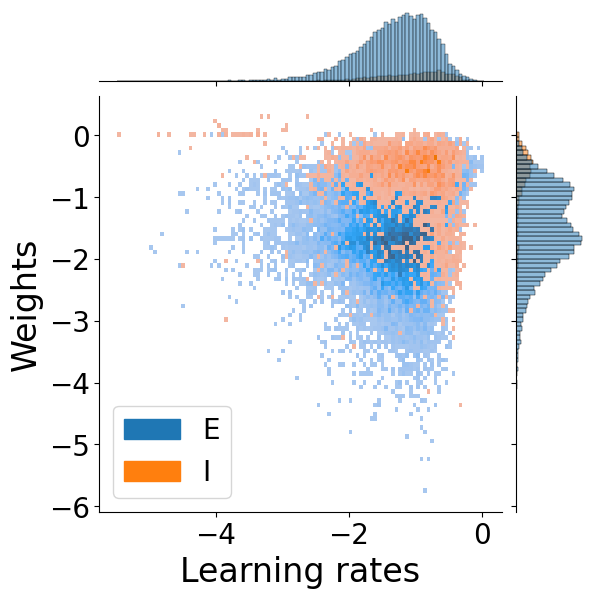

In [23]:
import seaborn as sns
import scipy.stats as stats
ei_label = np.empty(torch.sum(model.rnn.h2h.mask.squeeze().flatten().abs()>0).long().item(), dtype=object)
ei_label[model.rnn.h2h.mask.squeeze().flatten()[model.rnn.h2h.mask.squeeze().flatten().abs()>0]>0] = 'E'
ei_label[model.rnn.h2h.mask.squeeze().flatten()[model.rnn.h2h.mask.squeeze().flatten().abs()>0]<0] = 'I'
sjp = sns.jointplot(x=np.log10(model.rnn.kappa_rec.squeeze().abs().detach().flatten()[model.rnn.h2h.mask.squeeze().flatten().abs()>0]),
                    y=np.log10(model.rnn.h2h.effective_weight().detach().flatten().abs()[model.rnn.h2h.mask.squeeze().flatten().abs()>0]),
                    hue=ei_label, kind='hist')
sjp.set_axis_labels('Learning rates', 'Weights', fontsize=24)
sns.move_legend(sjp.ax_joint, 'lower left')

# a, b = np.polyfit(np.log10(model.rnn.kappa_rec.squeeze().abs().detach().flatten()[model.rnn.h2h.mask.squeeze().flatten().abs()>0]), \
#                   np.log10(model.rnn.h2h.effective_weight().detach().flatten().abs()[model.rnn.h2h.mask.squeeze().flatten().abs()>0]), 1)
# plt.plot(np.linspace(-4, 0, 100), a*np.linspace(-4, 0, 100)+b, c='k')
# stats.spearmanr(np.log10(model.rnn.kappa_rec.squeeze().abs().detach().flatten()[model.rnn.h2h.mask.squeeze().flatten().abs()>0]), \
#                 np.log10(model.rnn.h2h.effective_weight().detach().flatten().abs()[model.rnn.h2h.mask.squeeze().flatten().abs()>0]))

# Subspace Analysis


### Decompose each input pattern as a sum of feature, conjunction, and object patterns
$I_{in,i} = I_{ft}(i)+I_{conj}(i)+I_{obj}(i)$

In [5]:
input_weight_inds = list(range(E_SIZE)) + list(range(E_SIZE*args['num_areas'], E_SIZE*args['num_areas']+I_SIZE))
output_weight_inds = list(range(E_SIZE, 2*E_SIZE)) + list(range(E_SIZE*args['num_areas']+I_SIZE, E_SIZE*args['num_areas']+2*I_SIZE))

stims, global_avg_in, ft_avg_in, conj_avg_in, obj_avg_in = get_input_encodings(
    model.rnn.x2h.effective_weight()[input_weight_inds].detach().numpy(), 
    task_mdprl.stim_encoding('all_onehot'))

# global_avg_out, ft_avg_out, conj_avg_out, obj_avg_out = get_input_encodings(
#     model.h2o.effective_weight().detach().numpy().T, np.eye(27))

## Use dPCA to get ft/conj/obj specific axes in the input and output weights

In [6]:
n_components_for_dpca = {'s':2, 'p':2, 'c':2, 'sc':4, 'sp':4, 'pc':4, 'spc': 8}

dpca_in = dPCA.dPCA('spc', n_components=n_components_for_dpca, regularizer=None)
low_stims = dpca_in.fit_transform(stims.reshape((80,3,3,3)))

expanded_h2o = torch.cat([model.h2o.effective_weight().detach(), torch.zeros(27, I_SIZE)], dim=1)
dpca_out = dPCA.dPCA('spc', n_components=n_components_for_dpca, regularizer=None)
low_output = dpca_out.fit_transform(expanded_h2o.numpy().T.reshape((80,3,3,3)))

dpca_ch = dPCA.dPCA('spc', n_components=n_components_for_dpca, regularizer=None)
low_ch = dpca_ch.fit_transform(model.rnn.aux2h.effective_weight().detach().numpy()[list(range(64, 128))+list(range(144, 160)),2:].reshape((80,3,3,3)))

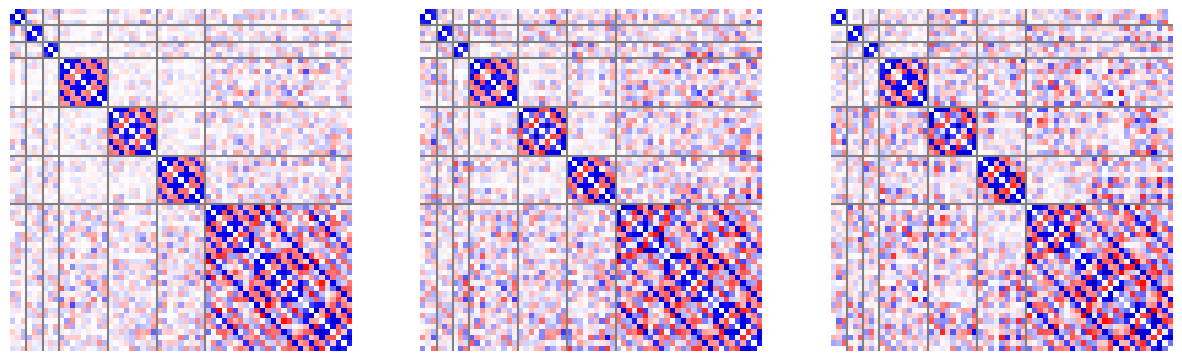

In [7]:
all_dpca_psth_in = np.concatenate([dpca_in.marginalized_psth['s'].squeeze(), 
                                   dpca_in.marginalized_psth['p'].squeeze(), 
                                   dpca_in.marginalized_psth['c'].squeeze(), 
                                   dpca_in.marginalized_psth['pc'].squeeze().reshape((args['hidden_size'], 9)), 
                                   dpca_in.marginalized_psth['sc'].squeeze().reshape((args['hidden_size'], 9)), 
                                   dpca_in.marginalized_psth['sp'].squeeze().reshape((args['hidden_size'], 9)), 
                                   dpca_in.marginalized_psth['spc'].squeeze().reshape((args['hidden_size'], 27))], 
                                   axis=1)

all_dpca_psth_out = np.concatenate([dpca_out.marginalized_psth['s'].squeeze(), 
                                   dpca_out.marginalized_psth['p'].squeeze(), 
                                   dpca_out.marginalized_psth['c'].squeeze(), 
                                   dpca_out.marginalized_psth['pc'].squeeze().reshape((args['hidden_size'], 9)), 
                                   dpca_out.marginalized_psth['sc'].squeeze().reshape((args['hidden_size'], 9)), 
                                   dpca_out.marginalized_psth['sp'].squeeze().reshape((args['hidden_size'], 9)), 
                                   dpca_out.marginalized_psth['spc'].squeeze().reshape((args['hidden_size'], 27))], 
                                   axis=1)

all_dpca_psth_ch = np.concatenate([dpca_ch.marginalized_psth['s'].squeeze(), 
                                   dpca_ch.marginalized_psth['p'].squeeze(), 
                                   dpca_ch.marginalized_psth['c'].squeeze(), 
                                   dpca_ch.marginalized_psth['pc'].squeeze().reshape((args['hidden_size'], 9)), 
                                   dpca_ch.marginalized_psth['sc'].squeeze().reshape((args['hidden_size'], 9)), 
                                   dpca_ch.marginalized_psth['sp'].squeeze().reshape((args['hidden_size'], 9)), 
                                   dpca_ch.marginalized_psth['spc'].squeeze().reshape((args['hidden_size'], 27))], 
                                   axis=1)


fig, axes = plt.subplots(1,3)
fig.set_size_inches((15, 8))
axes[0].imshow(batch_cosine_similarity(all_dpca_psth_in.T, all_dpca_psth_in.T)-np.eye(63),
           cmap='seismic', vmin=-1, vmax=1)
axes[1].imshow(batch_cosine_similarity(all_dpca_psth_out.T, all_dpca_psth_out.T)-np.eye(63),
           cmap='seismic', vmin=-1, vmax=1)
axes[2].imshow(batch_cosine_similarity(all_dpca_psth_ch.T, all_dpca_psth_ch.T)-np.eye(63),
           cmap='seismic', vmin=-1, vmax=1)

block_boundaries = [2.5, 5.5, 8.5, 17.5, 26.5, 35.5]
for i in range(3):
    axes[i].axis('off')
    for bb in block_boundaries:
        axes[i].axvline(x=bb,color='grey')
        axes[i].axhline(y=bb,color='grey')
    
    

<BarContainer object of 63 artists>

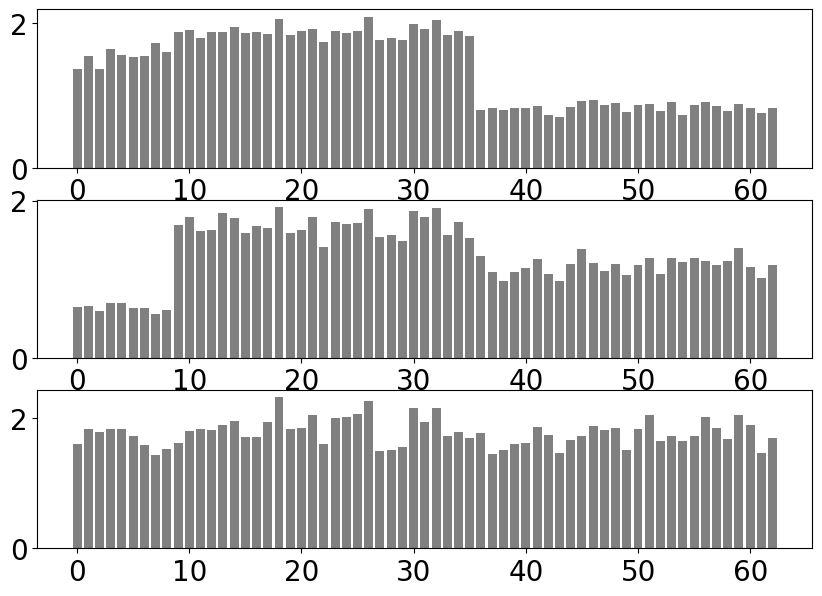

In [8]:
fig, axes = plt.subplots(3,1)

axes[0].bar(np.arange(63), np.linalg.norm(all_dpca_psth_in, axis=0), color='grey')
axes[1].bar(np.arange(63), np.linalg.norm(all_dpca_psth_out, axis=0), color='grey')
axes[2].bar(np.arange(63), np.linalg.norm(all_dpca_psth_ch, axis=0), color='grey')

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found

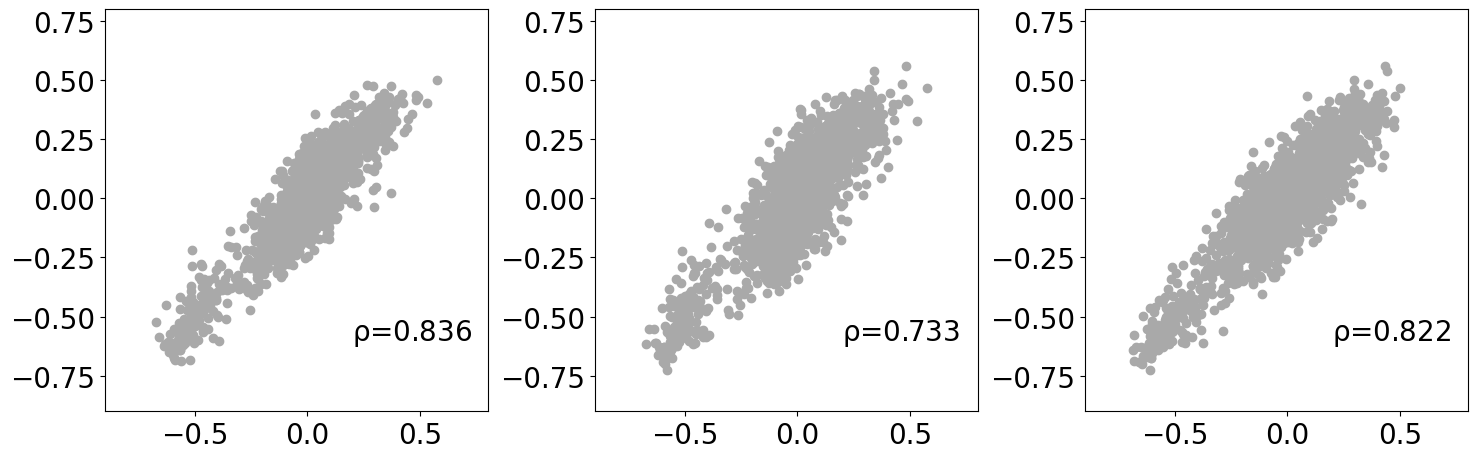

In [11]:
triu_inds = np.triu_indices(63, k = 1)

fig, axes = plt.subplots(1, 3)
fig.set_size_inches((15, 5))

dpca_in_rdm = batch_cosine_similarity(all_dpca_psth_in.T, all_dpca_psth_in.T)[triu_inds]
dpca_out_rdm = batch_cosine_similarity(all_dpca_psth_out.T, all_dpca_psth_out.T)[triu_inds]
dpca_ch_rdm = batch_cosine_similarity(all_dpca_psth_ch.T, all_dpca_psth_ch.T)[triu_inds]

axes[0].scatter(dpca_in_rdm, dpca_out_rdm, color='darkgrey')
temp_corr = spearmanr(dpca_in_rdm, dpca_out_rdm)
axes[0].text(0.2, -0.6, fr"$\rho$={np.round(temp_corr.correlation, 3)}")
axes[1].scatter(dpca_in_rdm, dpca_ch_rdm, color='darkgrey')
temp_corr = spearmanr(dpca_in_rdm, dpca_ch_rdm)
axes[1].text(0.2, -0.6, fr"$\rho$={np.round(temp_corr.correlation, 3)}")
axes[2].scatter(dpca_out_rdm, dpca_ch_rdm, color='darkgrey')
temp_corr = spearmanr(dpca_out_rdm, dpca_ch_rdm)
axes[2].text(0.2, -0.6, fr"$\rho$={np.round(temp_corr.correlation, 3)}")

for i in range(3):
    axes[i].set_xlim([-0.9, 0.8])
    axes[i].set_ylim([-0.9, 0.8])
plt.tight_layout()
plt.show()

Figure saved at plots/exp/dual_hierarchical_good_based/input_output_weight_variance.pdf


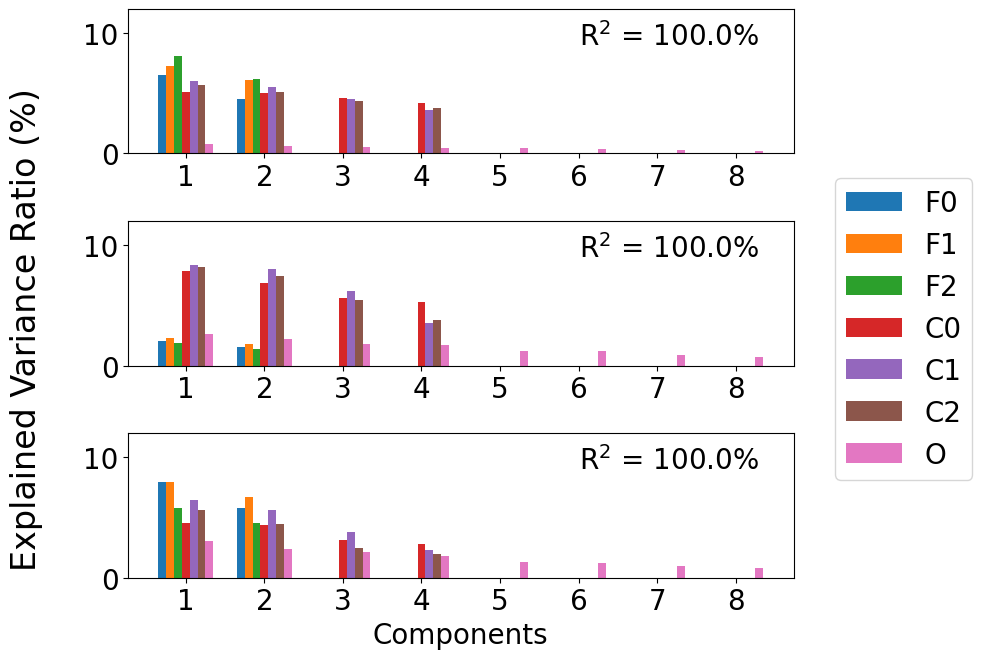

In [12]:
fig, axes = plt.subplots(3,1)

bar_width = 0.1
labels = ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O']

key_plot_order = ['s', 'p', 'c', 'pc', 'sc', 'sp', 'spc']

for k_idx, k in enumerate(key_plot_order):
    bar_x = np.arange(len(dpca_in.explained_variance_ratio_[k]))
    axes[0].bar(bar_x+bar_width*(k_idx-len(low_stims.keys())//2), np.array(dpca_in.explained_variance_ratio_[k])*100, width=bar_width, label=labels[k_idx])
    axes[1].bar(bar_x+bar_width*(k_idx-len(low_stims.keys())//2), np.array(dpca_out.explained_variance_ratio_[k])*100, width=bar_width, label=labels[k_idx])
    axes[2].bar(bar_x+bar_width*(k_idx-len(low_stims.keys())//2), np.array(dpca_ch.explained_variance_ratio_[k])*100, width=bar_width, label=labels[k_idx])

axes[2].set_xlabel('Components')
axes[0].set_xticks(np.arange(0,8,1))
axes[1].set_xticks(np.arange(0,8,1))
axes[2].set_xticks(np.arange(0,8,1))
axes[0].set_xticklabels(np.arange(1,9,1))
axes[1].set_xticklabels(np.arange(1,9,1))
axes[2].set_xticklabels(np.arange(1,9,1))
axes[0].set_ylim([-0.0, 12])
axes[1].set_ylim([-0.0, 12])
axes[2].set_ylim([-0.0, 12])
fig.supylabel('Explained Variance Ratio (%)')
plt.tight_layout()
handles, labels = axes[0].get_legend_handles_labels()
box = axes[0].get_position()
axes[0].text(5, 9, rf'$R^2$ = {100*np.round(np.sum([np.sum(v) for v in dpca_in.explained_variance_ratio_.values()]))}%')
axes[0].set_position([box.x0, box.y0, box.width * 0.8, box.height])
box = axes[1].get_position()
axes[1].text(5, 9, rf'$R^2$ = {100*np.round(np.sum([np.sum(v) for v in dpca_out.explained_variance_ratio_.values()]))}%')
axes[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
box = axes[2].get_position()
axes[2].text(5, 9, rf'$R^2$ = {100*np.round(np.sum([np.sum(v) for v in dpca_ch.explained_variance_ratio_.values()]))}%')
axes[2].set_position([box.x0, box.y0, box.width * 0.8, box.height])
fig.legend(handles, labels, loc='center right')
fig.show()

with PdfPages(f'plots/{args["exp_dir"]}/input_output_weight_variance.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{args["exp_dir"]}/input_output_weight_variance.pdf')


Figure saved at plots/exp/dual_hierarchical_good_based/input_axis_overlap.pdf


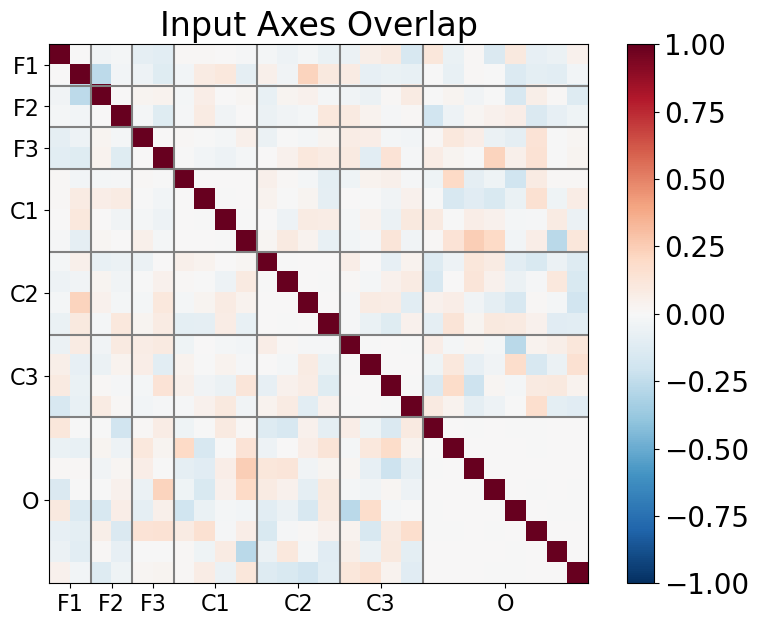

In [13]:
all_dpca_axes = np.concatenate([dpca_in.P['s'], dpca_in.P['p'], dpca_in.P['c'], 
                                dpca_in.P['pc'], dpca_in.P['sc'], dpca_in.P['sp'], 
                                dpca_in.P['spc']], axis=1)
axes_overlap = all_dpca_axes.T@all_dpca_axes
# sig_thresh = np.abs(norm.ppf(0.05/(26*25/2-3-7*3-28))/np.sqrt(100))
sig_thresh = np.abs(norm.ppf(0.001)/np.sqrt(args['hidden_size']))
axes_corr_val, axes_corr_ps = spearmanr(all_dpca_axes, axis=0)


plt.imshow(axes_overlap, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Input Axes Overlap')
plt.xlabel('')

txs, tys = np.meshgrid(np.arange(sum(n_components_for_dpca.values())),np.arange(sum(n_components_for_dpca.values())))
txs = txs[(np.abs(axes_overlap)>sig_thresh) & (axes_corr_ps<0.001)]
tys = tys[(np.abs(axes_overlap)>sig_thresh) & (axes_corr_ps<0.001)]

block_boundaries = np.cumsum(list(n_components_for_dpca.values()))[:-1]-0.5
for i in block_boundaries:
    plt.axvline(x=i,color='grey')
    plt.axhline(y=i,color='grey')
    
tick_locs = np.cumsum([0, *n_components_for_dpca.values()])[:-1]+np.array(list(n_components_for_dpca.values()))//2-0.5

plt.xticks(tick_locs, ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=16)
plt.yticks(tick_locs, ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=16)

for (x,y) in zip(txs, tys):
    if x<=y:
        continue
    else:
        plt.text(x-0.25, y+0.55, '*', {'size': 16})
        
with PdfPages(f'plots/{args["exp_dir"]}/input_axis_overlap.pdf') as pdf:
    pdf.savefig()
    print(f'Figure saved at plots/{args["exp_dir"]}/input_axis_overlap.pdf')

Figure saved at plots/exp/dual_hierarchical_good_based/output_axis_overlap.pdf


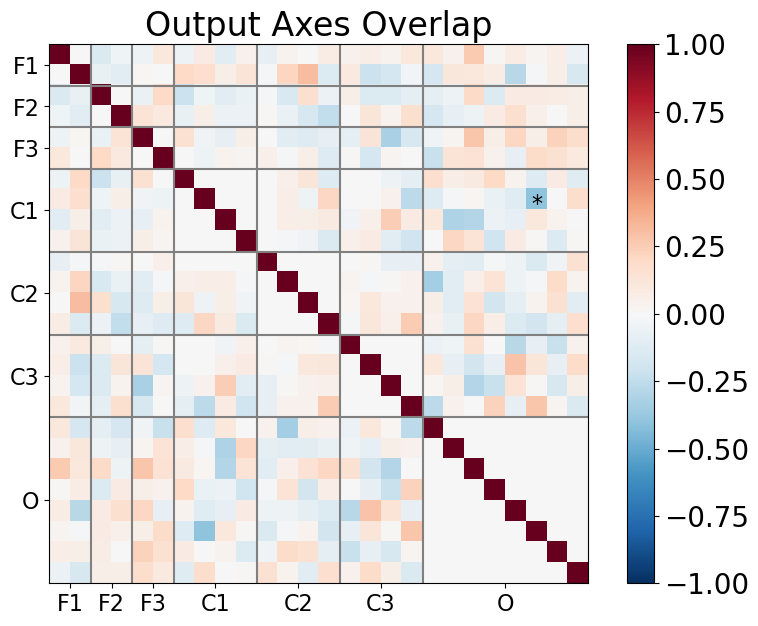

In [14]:
all_dpca_axes = np.concatenate([dpca_out.P['s'], dpca_out.P['p'], dpca_out.P['c'], 
                                dpca_out.P['pc'], dpca_out.P['sc'], dpca_out.P['sp'], 
                                dpca_out.P['spc']], axis=1)
axes_overlap = all_dpca_axes.T@all_dpca_axes
# sig_thresh = np.abs(norm.ppf(0.05/(26*25/2-3-7*3-28))/np.sqrt(100))
sig_thresh = np.abs(norm.ppf(0.001)/np.sqrt(args['hidden_size']))

axes_corr_val, axes_corr_ps = spearmanr(all_dpca_axes, axis=0)

plt.imshow(axes_overlap, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Output Axes Overlap')
plt.xlabel('')

txs, tys = np.meshgrid(np.arange(6+12+8),np.arange(6+12+8))
txs = txs[(np.abs(axes_overlap)>sig_thresh) & (axes_corr_ps<0.001)]
tys = tys[(np.abs(axes_overlap)>sig_thresh) & (axes_corr_ps<0.001)]

block_boundaries = np.cumsum(list(n_components_for_dpca.values()))[:-1]-0.5
for i in block_boundaries:
    plt.axvline(x=i,color='grey')
    plt.axhline(y=i,color='grey')
    
plt.xticks([0.5,2.5,4.5,7.5,11.5,15.5,21.5], ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=16)
plt.yticks([0.5,2.5,4.5,7.5,11.5,15.5,21.5], ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=16)

for (x,y) in zip(txs, tys):
    if x<=y:
        continue
    else:
        plt.text(x-0.25, y+0.55, '*', {'size': 16})
        
with PdfPages(f'plots/{args["exp_dir"]}/output_axis_overlap.pdf') as pdf:
    pdf.savefig()
    print(f'Figure saved at plots/{args["exp_dir"]}/output_axis_overlap.pdf')
        

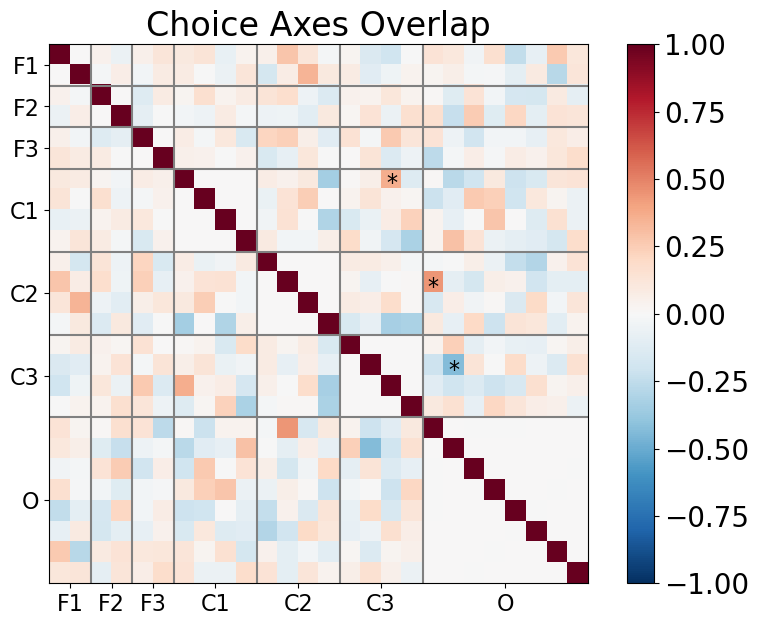

In [15]:
all_dpca_axes = np.concatenate([dpca_ch.P['s'], dpca_ch.P['p'], dpca_ch.P['c'], 
                                dpca_ch.P['pc'], dpca_ch.P['sc'], dpca_ch.P['sp'], 
                                dpca_ch.P['spc']], axis=1)
axes_overlap = all_dpca_axes.T@all_dpca_axes
sig_thresh = np.abs(norm.ppf(0.001)/np.sqrt(args['hidden_size']))

axes_corr_val, axes_corr_ps = spearmanr(all_dpca_axes, axis=0)

plt.imshow(axes_overlap, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Choice Axes Overlap')
plt.xlabel('')

txs, tys = np.meshgrid(np.arange(6+12+8),np.arange(6+12+8))
txs = txs[(np.abs(axes_overlap)>sig_thresh) & (axes_corr_ps<0.001)]
tys = tys[(np.abs(axes_overlap)>sig_thresh) & (axes_corr_ps<0.001)]

block_boundaries = [1.5, 3.5, 5.5, 9.5, 13.5, 17.5]
for i in block_boundaries:
    plt.axvline(x=i,color='grey')
    plt.axhline(y=i,color='grey')
    
plt.xticks([0.5,2.5,4.5,7.5,11.5,15.5,21.5], ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=16)
plt.yticks([0.5,2.5,4.5,7.5,11.5,15.5,21.5], ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=16)

for (x,y) in zip(txs, tys):
    if x<=y:
        continue
    else:
        plt.text(x-0.25, y+0.55, '*', {'size': 16})
        
# with PdfPages(f'plots/{args["exp_dir"]}/output_axis_overlap.pdf') as pdf:
#     pdf.savefig()
#     print(f'Figure saved at plots/{args["exp_dir"]}/output_axis_overlap.pdf')
        

The input and output weights are both low-rank, and their encoding subspaces have very little overlap.

# dPCA Analysis of the Activity of the RNN

In [22]:
def get_area_ei_indices(args, ind_area):
    hidden_size_per_area = args['hidden_size']
    E_SIZE = round(args['hidden_size']*args['e_prop'])
    I_SIZE = round(args['hidden_size']*(1-args['e_prop']))
    NUM_AREAS = args['num_areas']
    return np.concatenate([np.arange(E_SIZE*ind_area, E_SIZE*(ind_area+1)), 
                           np.arange(E_SIZE*NUM_AREAS+I_SIZE*ind_area, E_SIZE*NUM_AREAS+I_SIZE*(ind_area+1))])

def make_dpca_results(Xs, labels, n_components):
    all_non_time_labels = labels
    join_dict = {}
    for r in range(1, len(labels)+1):
        for label in list(itertools.combinations(all_non_time_labels, r)):
            label_str = ''.join(label)
            join_dict['t'+label_str] = [label_str, 't'+label_str]

    dpca_model = dPCA.dPCA('t'+labels, join=join_dict, n_components=n_components)
    low_hs = dpca_model.fit_transform(Xs)

    all_axes = []
    all_explained_vars = []
    all_labels = []
    for k in dpca_model.marginalized_psth.keys():
        if k=='t':
            continue
        eff_components = np.sum(np.array(dpca_model.explained_variance_ratio_[k])>0.00)
        all_explained_vars.append(dpca_model.explained_variance_ratio_[k][:eff_components])
        print(f"Variance explained by {eff_components} of {k}: {np.round(100*np.array(dpca_model.explained_variance_ratio_[k]),4)} %")
        all_axes.append(dpca_model.P[k][:,:eff_components])
        all_labels += [k]*eff_components

    all_axes = np.concatenate(all_axes, axis=1)
    all_explained_vars = np.concatenate(all_explained_vars, axis=0)

    dpca_results = {}
    dpca_results['low_hs'] = low_hs
    dpca_results['encoding_axes'] = dpca_model.P
    dpca_results['explained_variances'] = all_explained_vars
    dpca_results['marginalized_psth'] = dpca_model.marginalized_psth

    return dpca_results

def get_dpca_by_area(all_saved_states, task_mdprl, args, num_trials_to_fit=432, area_to_fit=1):
    '''
    (1) regress hs activity with
            previous trial choice shape, color, pattern (3x3x3), 
            previous trial reward (2),
            current trial stimuli shape, color, pattern pairs (3x3x3), 
            current trial choice shape, color, pattern (3x3x3), 
            current trial reward (2),
    (2) get beta weights which is a mixture of value and stimulus intensity: h ~ Xw. 
        This will give beta weights timepoints X trials X hidden X latent variables,
        calculate cpd gives timepoints X trials X hidden X latent variables CPD values
    (3) compare w with marginal reward probability? see which it dimension it corresponds to the best
    '''
    
    n_trials, n_timesteps, n_sessions, n_hidden = all_saved_states['hs'].shape
    n_areas = args['num_areas'] 
    n_hidden = n_hidden//n_areas
    area_inds = get_area_ei_indices(args, area_to_fit)
    area_hs = all_saved_states['hs'][...,area_inds]

    print("Calculating PSTH by prev trial")

    '''
    organize by previous trial outcome
    '''
    hs_by_prev = np.zeros((n_hidden, n_timesteps, 2, 3, 3, 3)) # sort data by previous trial choices and outcomes

    flat_hs_post = area_hs.numpy()[1:num_trials_to_fit,...].transpose((2,0,1,3)).reshape((n_sessions*(num_trials_to_fit-1), n_timesteps, n_hidden))
    flat_rwds_pre = all_saved_states['rewards'].numpy()[:num_trials_to_fit-1,...].transpose((2,0,1)).reshape((n_sessions*(num_trials_to_fit-1))).astype(int)
    flat_acts_pre = all_saved_states['choices'].numpy()[:num_trials_to_fit-1,...].transpose((2,0,1)).reshape((n_sessions*(num_trials_to_fit-1))).astype(int)

    # the prev_f{}_vals are IN TERMS OF THE REWARD SCHEDULE, NOT THE PERCEPTUAL DIMENSIONS

    act_f1_val = task_mdprl.index_shp[flat_acts_pre]
    act_f2_val = task_mdprl.index_pttrn[flat_acts_pre]
    act_f3_val = task_mdprl.index_clr[flat_acts_pre]

    n_components_for_dpca_by_prev = {'t':5, 'tr':1, 'ts':2, 'tp':2, 'tc':2, 'tsp':4, 'tsc':4, 'tpc':4, 'tspc': 8,
                                     'trs':2, 'trp':2, 'trc':2, 'trsp':4, 'trsc':4, 'trpc':4, 'trspc': 8,}
    
    for prev_rwd_val in range(2):
        for prev_f1_val in range(3): 
            for prev_f2_val in range(3):
                for prev_f3_val in range(3):
                    # n_trials, 1, n_sessions, ...
                    where_trial = (flat_rwds_pre==prev_rwd_val) & \
                                  (act_f1_val==prev_f1_val) & \
                                  (act_f2_val==prev_f2_val) & \
                                  (act_f3_val==prev_f3_val)
                    hs_by_prev[:, :, prev_rwd_val, prev_f1_val, prev_f2_val, prev_f3_val] = flat_hs_post[where_trial,...].mean(0).T

    del flat_hs_post
    del flat_rwds_pre
    del flat_acts_pre
    
    '''
    organize by current trial stimuli
    '''
    print("Calculating PSTH by current trial stimuli")

    n_components_for_dpca_by_curr_stim = {'t':5, 'ts':2, 'tp':2, 'tc':2, 'tsp':4, 'tsc':4, 'tpc':4, 'tspc': 8}

    hs_by_curr_stim = np.zeros((n_hidden, n_timesteps, 6, 6, 6)) # sort data by current trial choices and outcomes

    flat_hs_curr = area_hs[:num_trials_to_fit].numpy().transpose((2,0,1,3)).reshape((n_sessions*num_trials_to_fit, n_timesteps, n_hidden))
    flat_stims = all_saved_states['stimuli'][:num_trials_to_fit].numpy().transpose((2,0,1,3)).reshape((n_sessions*num_trials_to_fit, 2)).astype(int)

    pair_to_ind = {(0,1): 0, (1,0): 1, (0,2): 2, (2,0): 3, (1,2): 4, (2,1): 5}

    stim_f1_val = np.ones_like(flat_stims[:,0])*np.nan
    stim_f2_val = np.ones_like(flat_stims[:,0])*np.nan
    stim_f3_val = np.ones_like(flat_stims[:,0])*np.nan
    
    for k, v in pair_to_ind.items():
        stim_f1_val[(task_mdprl.index_shp[flat_stims[:,0]]==k[0]) & (task_mdprl.index_shp[flat_stims[:,1]]==k[1])] = v
        stim_f2_val[(task_mdprl.index_pttrn[flat_stims[:,0]]==k[0]) & (task_mdprl.index_pttrn[flat_stims[:,1]]==k[1])] = v
        stim_f3_val[(task_mdprl.index_clr[flat_stims[:,0]]==k[0]) & (task_mdprl.index_clr[flat_stims[:,1]]==k[1])] = v
    
    for curr_f1_val in range(6):
        for curr_f2_val in range(6):
            for curr_f3_val in range(6):
                # n_trials, 1, n_sessions, ...

#                 print(task_mdprl.index_shp[flat_stims[:,0]], task_mdprl.index_pttrn[flat_stims[:,0]], task_mdprl.index_clr[flat_stims[:,0]])
#                 print(task_mdprl.index_shp[flat_stims[:,1]], task_mdprl.index_pttrn[flat_stims[:,1]], task_mdprl.index_clr[flat_stims[:,1]])
#                 print(stim_f1_val, stim_f2_val, stim_f3_val)
                where_trial = (stim_f1_val==curr_f1_val) & \
                              (stim_f2_val==curr_f2_val) & \
                              (stim_f3_val==curr_f3_val)
                hs_by_curr_stim[:, :, curr_f1_val, curr_f2_val, curr_f3_val] = flat_hs_curr[where_trial,...].mean(0).T

    del flat_stims

    '''
    organize by current trial outcome
    '''
    print("Calculating PSTH by current trial outcome")

    n_components_for_dpca_by_curr_outcome = {'t':5, 'tr':1, 'ts':2, 'tp':2, 'tc':2, 'tsp':4, 'tsc':4, 'tpc':4, 'tspc': 8,
                                             'trs':2, 'trp':2, 'trc':2, 'trsp':4, 'trsc':4, 'trpc':4, 'trspc': 8,}

    hs_by_curr_outcome = np.zeros((n_hidden, n_timesteps, 2, 3, 3, 3)) # sort data by previous trial choices and outcomes
    flat_rwds_curr = all_saved_states['rewards'][:num_trials_to_fit,...].numpy().transpose((2,0,1)).reshape((n_sessions*num_trials_to_fit)).astype(int)
    flat_acts_curr = all_saved_states['choices'][:num_trials_to_fit,...].numpy().transpose((2,0,1)).reshape((n_sessions*num_trials_to_fit)).astype(int)

    act_f1_val = task_mdprl.index_shp[flat_acts_curr]
    act_f2_val = task_mdprl.index_pttrn[flat_acts_curr]
    act_f3_val = task_mdprl.index_clr[flat_acts_curr]

    for curr_rew_val in range(2):
        for curr_f1_val in range(3):
            for curr_f2_val in range(3):
                for curr_f3_val in range(3):
                    # n_trials, 1, n_sessions, ...
                    where_trial = (flat_rwds_curr==curr_rew_val) & \
                                  (act_f1_val==curr_f1_val) & \
                                  (act_f2_val==curr_f2_val) & \
                                  (act_f3_val==curr_f3_val)
                    hs_by_curr_outcome[:, :, curr_rew_val, curr_f1_val, curr_f2_val, curr_f3_val] = flat_hs_curr[where_trial,...].mean(0).T
         
    del flat_hs_curr
    del flat_rwds_curr
    del flat_acts_curr


    print("-------------------------------------------")
    print('Calculating DPCA by previous trial outcome')
    dpca_results_by_prev = make_dpca_results(hs_by_prev, "rspc", n_components=n_components_for_dpca_by_prev)
    print("-------------------------------------------")
    print('Calculating DPCA by current trial stimuli')
    dpca_results_by_curr_stim = make_dpca_results(hs_by_curr_stim, "spc", n_components=n_components_for_dpca_by_curr_stim)
    print("-------------------------------------------")
    print('Calculating DPCA by current trial outcome')
    dpca_results_by_curr_outcome = make_dpca_results(hs_by_curr_outcome, "rspc", n_components=n_components_for_dpca_by_curr_outcome)

#     fig, axes = plt.subplots(2, 2)
#     for i in range(4):
#         plot_mean_and_std(axes[i//2, i%2], all_cpds[i].mean([0, 2]), 
#                           all_cpds[i].std([0, 2])/np.sqrt(n_trials//4*n_batch), label=['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'])
    return dpca_results_by_prev, dpca_results_by_curr_stim, dpca_results_by_curr_outcome

In [23]:
dpca_results_by_prev = []
dpca_results_by_curr_stim = []
dpca_results_by_curr_outcome = []

for idx_area in range(NUM_AREAS):
    area_dpca_by_prev, area_dpca_by_curr_stim, area_dpca_by_curr_outcome = \
                    get_dpca_by_area(all_saved_states, task_mdprl, args, area_to_fit=idx_area)
    dpca_results_by_prev.append(area_dpca_by_prev)
    dpca_results_by_curr_stim.append(area_dpca_by_curr_stim)
    dpca_results_by_curr_outcome.append(area_dpca_by_curr_outcome)

Calculating PSTH by prev trial
Calculating PSTH by current trial stimuli
Calculating PSTH by current trial outcome
-------------------------------------------
Calculating DPCA by previous trial outcome
Variance explained by 1 of tr: [0.0841] %
Variance explained by 2 of ts: [0.1004 0.0653] %
Variance explained by 2 of tp: [0.0874 0.0523] %
Variance explained by 2 of tc: [0.1205 0.0557] %
Variance explained by 2 of trs: [0.0369 0.0121] %
Variance explained by 2 of trp: [0.0223 0.0073] %
Variance explained by 2 of trc: [0.0288 0.0127] %
Variance explained by 4 of tsp: [0.2296 0.1775 0.0827 0.0783] %
Variance explained by 4 of tsc: [0.2579 0.1466 0.0744 0.0581] %
Variance explained by 4 of tpc: [0.1752 0.1829 0.0949 0.0638] %
Variance explained by 4 of trsp: [0.0506 0.0346 0.0122 0.0105] %
Variance explained by 4 of trsc: [0.0368 0.0234 0.0204 0.0106] %
Variance explained by 4 of trpc: [0.064  0.0239 0.012  0.0077] %
Variance explained by 8 of tspc: [0.0708 0.0614 0.0645 0.0438 0.0513 0.0

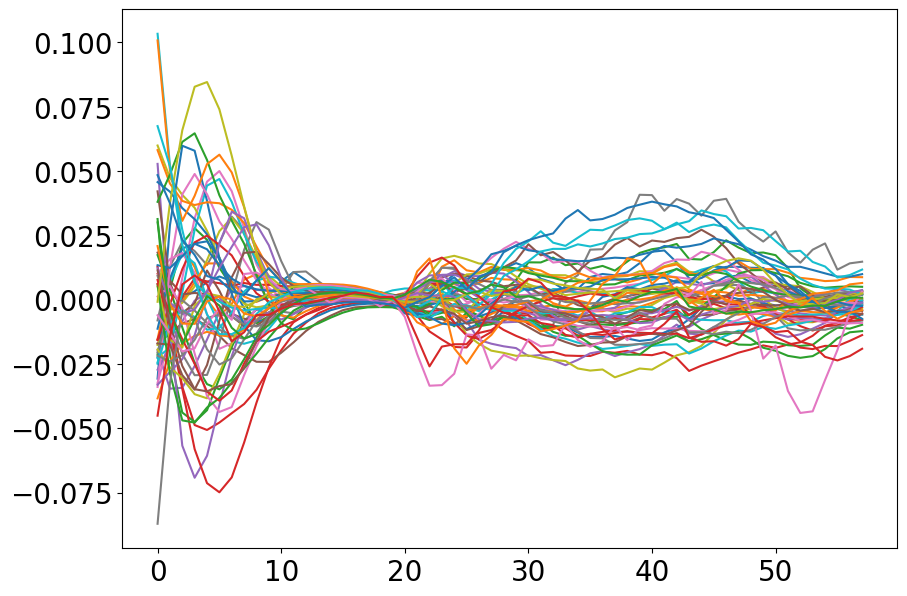

In [24]:
import matplotlib as mpl

flat_latent_vars = np.concatenate([task_mdprl.index_shp, 3+task_mdprl.index_shp],0)
for rwd_val in range(2):
    for ft_val in range(3):
        flat_low_hs = dpca_results_by_prev[1]['low_hs']['trp'].reshape((2, 58, -1))
        plt.plot(flat_low_hs[:,:,flat_latent_vars==(rwd_val*3+ft_val)][0]);


# flat_latent_vars = task_mdprl.index_shp

# ax = plt.figure().add_subplot(projection='3d')
# for ft_val in range(3):
#     flat_low_hs = dpca_results_by_prev[0]['low_hs']['trc'].reshape((2, 58, 2, 27))
#     ax.scatter(zs=np.repeat(np.arange(58), 18),
#                xs=flat_low_hs[:,:,:,flat_latent_vars==(ft_val)][1], 
#                ys=flat_low_hs[:,:,:,flat_latent_vars==(ft_val)][0]);

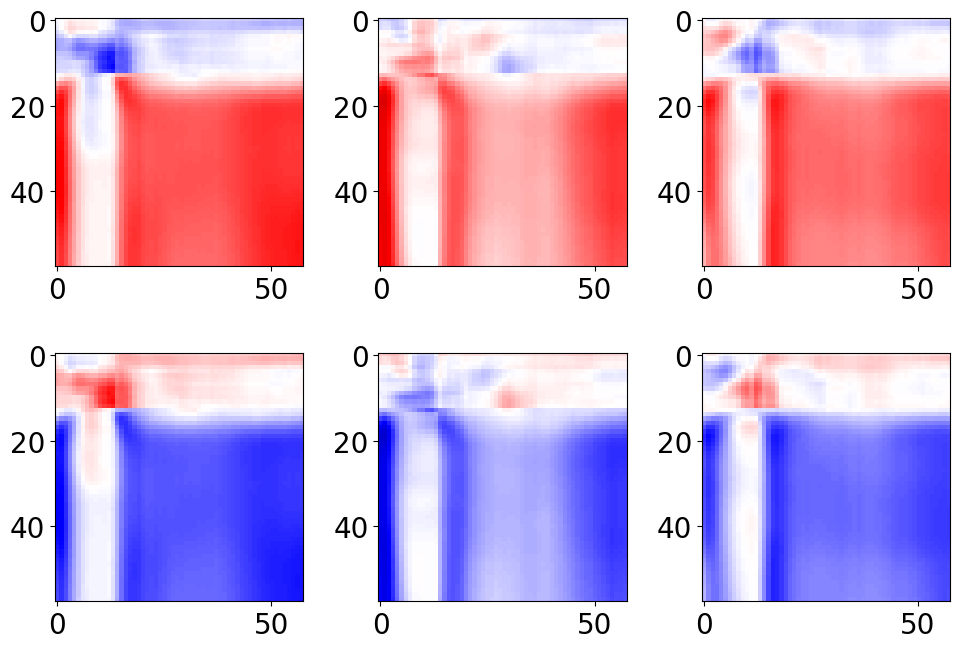

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

num_timesteps = dpca_results_by_curr_outcome[0]['marginalized_psth']['t'].shape[1]

# for ft_idx, ft_key in enumerate(['s','c','p']):
#     avg_corr = np.zeros((2, num_timesteps, num_timesteps))
#     for ft in range(3):
#         avg_corr[0,...] += cosine_similarity(
#                                         dpca_results_by_curr_outcome[1]['marginalized_psth']['t'+ft_key].squeeze()[:,:,ft].T, 
#                                         dpca_results_by_prev[1]['marginalized_psth']['tr'+ft_key].squeeze()[:,:,0,ft].T)
#         avg_corr[1,...] += cosine_similarity(
#                                         dpca_results_by_curr_outcome[1]['marginalized_psth']['t'+ft_key].squeeze()[:,:,ft].T, 
#                                         dpca_results_by_prev[1]['marginalized_psth']['tr'+ft_key].squeeze()[:,:,1,ft].T)
#     plt.subplot(230+ft_idx+1).imshow(avg_corr[0,...]/3, vmax=1, vmin=-1, cmap='seismic')
#     plt.subplot(230+ft_idx+4).imshow(avg_corr[1,...]/3, vmax=1, vmin=-1, cmap='seismic')
# #     plt.colorbar()

for conj_idx, conj_key in enumerate(['pc', 'sc', 'sp']):
    avg_corr = np.zeros((2, num_timesteps, num_timesteps))
    for ft1 in range(3):
        for ft2 in range(3):
            avg_corr[0,...] += batch_cosine_similarity(
                                    dpca_results_by_curr_outcome[0]['marginalized_psth']['t'+conj_key].squeeze()[:,:,ft1,ft2].T, 
                                    dpca_results_by_prev[0]['marginalized_psth']['tr'+conj_key].squeeze()[:,:,0,ft1,ft2].T)
            avg_corr[1,...] += batch_cosine_similarity(
                                    dpca_results_by_curr_outcome[0]['marginalized_psth']['t'+conj_key].squeeze()[:,:,ft1,ft2].T, 
                                    dpca_results_by_prev[0]['marginalized_psth']['tr'+conj_key].squeeze()[:,:,1,ft1,ft2].T)
    plt.subplot(230+conj_idx+1).imshow(avg_corr[0,...]/9, vmax=1, vmin=-1, cmap='seismic')
    plt.subplot(230+conj_idx+4).imshow(avg_corr[1,...]/9, vmax=1, vmin=-1, cmap='seismic')
#     plt.colorbar()

plt.tight_layout()

In [45]:
cosine_similarity(dpca_in.marginalized_psth[ft_key].squeeze()[:,ft][:,None].T,
                                dpca_results_by_curr_outcome[0]['marginalized_psth']['t'+ft_key].squeeze()[:,:,ft].T).shape

(1, 58)

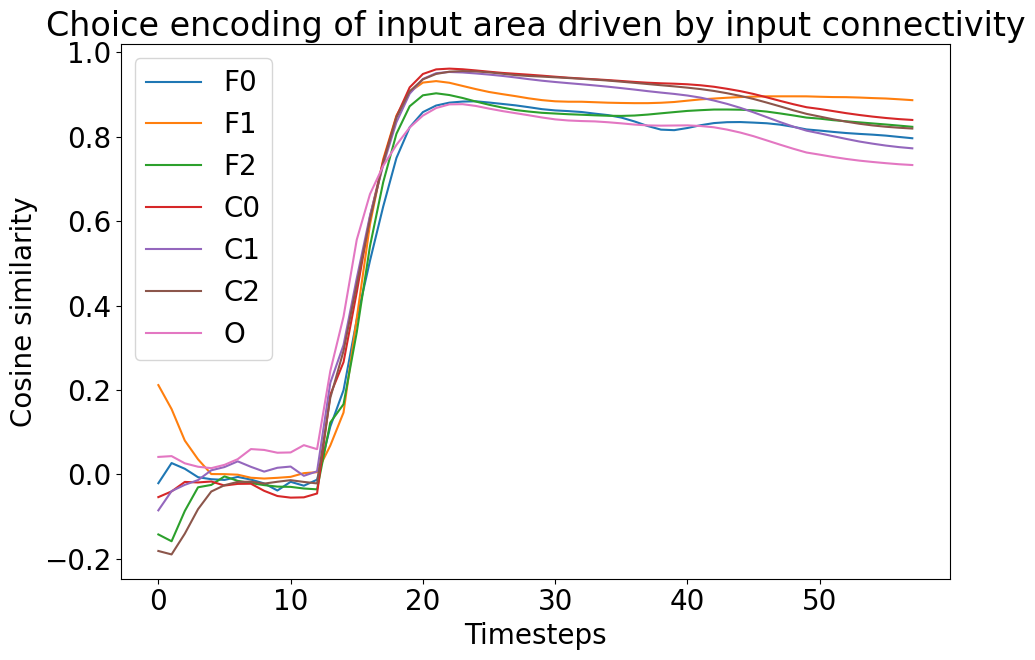

In [26]:
for ft_idx, ft_key in enumerate(['s','p','c']):
    avg_corr = np.zeros((num_timesteps,))
    for ft in range(3):
        avg_corr += cosine_similarity(dpca_in.marginalized_psth[ft_key].squeeze()[:,ft][:,None].T,
                                dpca_results_by_curr_outcome[0]['marginalized_psth']['t'+ft_key].squeeze()[:,:,ft].T).squeeze()
    plt.plot(avg_corr/3, label=f"F{ft_idx}")

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_corr = np.zeros((num_timesteps,))
    for ft1 in range(3):
        for ft2 in range(3):
            avg_corr += batch_cosine_similarity(dpca_in.marginalized_psth[conj_key].squeeze()[:,ft1,ft2][:,None].T,
                                    dpca_results_by_curr_outcome[0]['marginalized_psth']['t'+conj_key].squeeze()[:,:,ft1,ft2].T).squeeze()
    plt.plot(avg_corr/9, label=f"C{conj_idx}")
    
avg_corr = np.zeros((num_timesteps,))
for ft1 in range(3):
    for ft2 in range(3):
        for ft3 in range(3):
            avg_corr += batch_cosine_similarity(dpca_in.marginalized_psth['spc'].squeeze()[:,ft1,ft2,ft3][:,None].T,
                                    dpca_results_by_curr_outcome[0]['marginalized_psth']['tspc'].squeeze()[:,:,ft1,ft2,ft3].T).squeeze()
plt.plot(avg_corr/27, label='O')
    
plt.legend(ncol=1)
plt.ylabel('Cosine similarity')
plt.xlabel('Timesteps')
plt.yticks(np.linspace(-0.2, 1.0, 7))
plt.title('Choice encoding of input area driven by input connectivity')
plt.tight_layout()

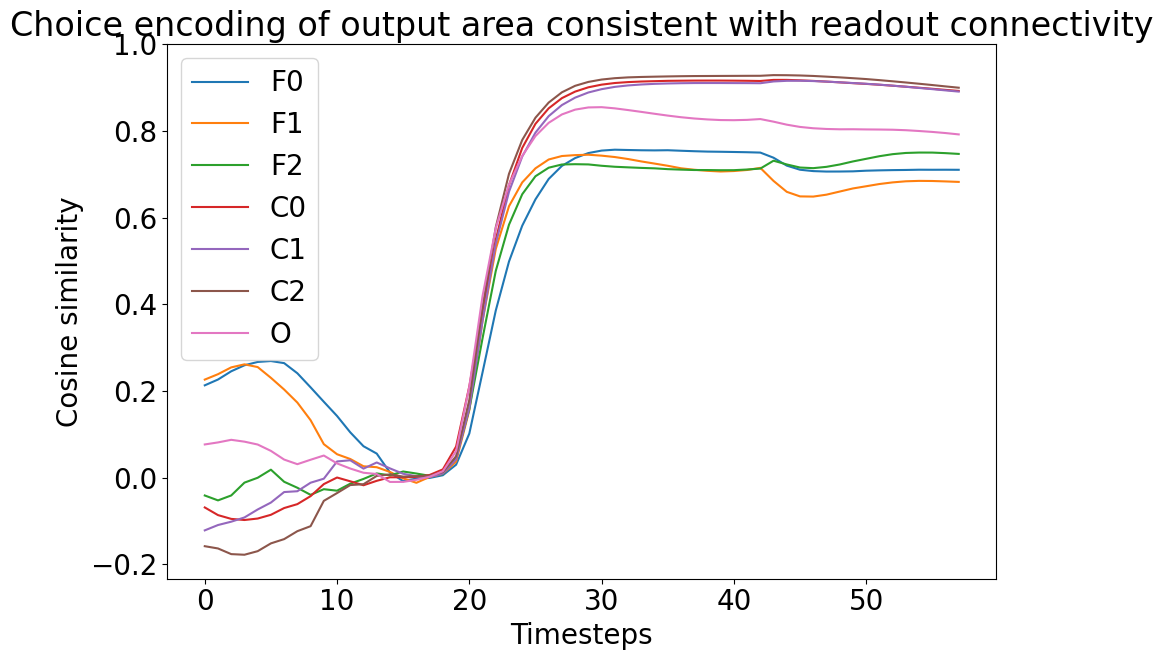

In [27]:
for ft_idx, ft_key in enumerate(['s','p','c']):
    avg_corr = np.zeros((num_timesteps,))
    for ft in range(3):
        avg_corr += cosine_similarity(dpca_out.marginalized_psth[ft_key].squeeze()[:,ft][:,None].T,
                                dpca_results_by_curr_outcome[1]['marginalized_psth']['t'+ft_key].squeeze()[:,:,ft].T).squeeze()
    plt.plot(avg_corr/3, label=f"F{ft_idx}")

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_corr = np.zeros((num_timesteps,))
    for ft1 in range(3):
        for ft2 in range(3):
            avg_corr += cosine_similarity(dpca_out.marginalized_psth[conj_key].squeeze()[:,ft1,ft2][:,None].T,
                                    dpca_results_by_curr_outcome[1]['marginalized_psth']['t'+conj_key].squeeze()[:,:,ft1,ft2].T).squeeze()
    plt.plot(avg_corr/9, label=f"C{conj_idx}")
    
avg_corr = np.zeros((num_timesteps,))
for ft1 in range(3):
    for ft2 in range(3):
        for ft3 in range(3):
            avg_corr += cosine_similarity(dpca_out.marginalized_psth['spc'].squeeze()[:,ft1,ft2,ft3][:,None].T,
                                    dpca_results_by_curr_outcome[1]['marginalized_psth']['tspc'].squeeze()[:,:,ft1,ft2,ft3].T).squeeze()
plt.plot(avg_corr/27, label='O')
    
plt.legend(ncol=1)
plt.ylabel('Cosine similarity')
plt.xlabel('Timesteps')
plt.yticks(np.linspace(-0.2, 1.0, 7))
plt.title('Choice encoding of output area consistent with readout connectivity')
plt.tight_layout()
plt.show()

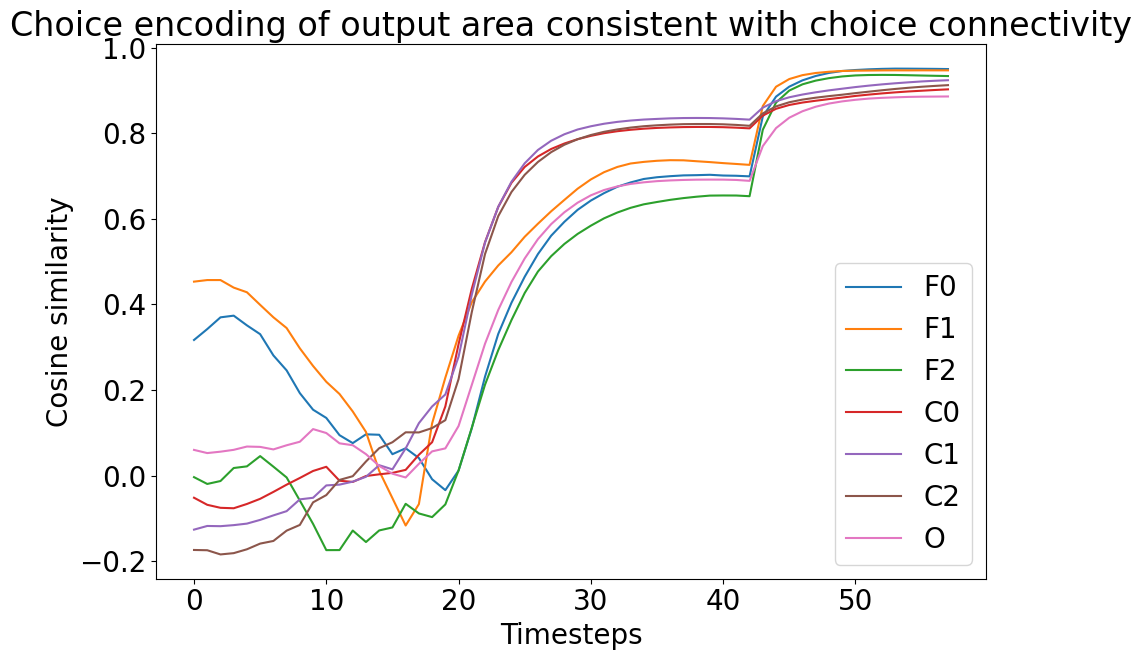

In [28]:
for ft_idx, ft_key in enumerate(['s','p','c']):
    avg_corr = np.zeros((num_timesteps,))
    for ft in range(3):
        avg_corr += cosine_similarity(dpca_ch.marginalized_psth[ft_key].squeeze()[:,ft][:,None].T,
                                dpca_results_by_curr_outcome[1]['marginalized_psth']['t'+ft_key].squeeze()[:,:,ft].T).squeeze()
    plt.plot(avg_corr/3, label=f"F{ft_idx}")

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_corr = np.zeros((num_timesteps,))
    for ft1 in range(3):
        for ft2 in range(3):
            avg_corr += cosine_similarity(dpca_ch.marginalized_psth[conj_key].squeeze()[:,ft1,ft2][:,None].T,
                                    dpca_results_by_curr_outcome[1]['marginalized_psth']['t'+conj_key].squeeze()[:,:,ft1,ft2].T).squeeze()
    plt.plot(avg_corr/9, label=f"C{conj_idx}")
    
avg_corr = np.zeros((num_timesteps,))
for ft1 in range(3):
    for ft2 in range(3):
        for ft3 in range(3):
            avg_corr += cosine_similarity(dpca_ch.marginalized_psth['spc'].squeeze()[:,ft1,ft2,ft3][:,None].T,
                                    dpca_results_by_curr_outcome[1]['marginalized_psth']['tspc'].squeeze()[:,:,ft1,ft2,ft3].T).squeeze()
plt.plot(avg_corr/27, label='O')
    
plt.legend(ncol=1)
plt.ylabel('Cosine similarity')
plt.xlabel('Timesteps')
plt.yticks(np.linspace(-0.2, 1.0, 7))
plt.title('Choice encoding of output area consistent with choice connectivity')
plt.tight_layout()
plt.show()

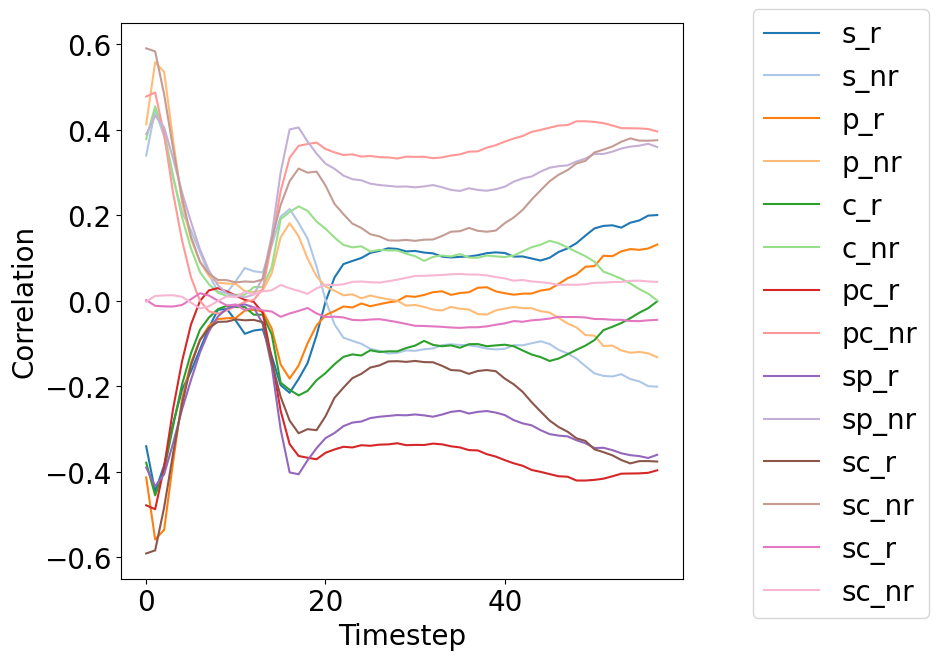

In [29]:
import matplotlib as mpl

for ft_idx, ft_key in enumerate(['s','p','c']):
    avg_corr = np.zeros((2, num_timesteps,))
    for ft in range(3):
        avg_corr[0] += batch_cosine_similarity(dpca_in.marginalized_psth[ft_key].squeeze()[:,ft][None],
                                dpca_results_by_prev[0]['marginalized_psth']['tr'+ft_key].squeeze()[:,:,0,ft].T).squeeze()
        avg_corr[1] += batch_cosine_similarity(dpca_in.marginalized_psth[ft_key].squeeze()[:,ft][None],
                                dpca_results_by_prev[0]['marginalized_psth']['tr'+ft_key].squeeze()[:,:,1,ft].T).squeeze()
    plt.plot(avg_corr[1]/3, label=ft_key+'_r', color=mpl.colormaps["tab20"](ft_idx*2))
    plt.plot(avg_corr[0]/3, label=ft_key+'_nr', color=mpl.colormaps["tab20"](ft_idx*2+1))

for conj_idx, conj_key in enumerate(['pc','sp','sc']):
    avg_corr = np.zeros((2,num_timesteps,))
    for ft1 in range(3):
        for ft2 in range(3):
            avg_corr[0] += batch_cosine_similarity(dpca_in.marginalized_psth[conj_key].squeeze()[:,ft1,ft2][None],
                                    dpca_results_by_prev[0]['marginalized_psth']['tr'+conj_key].squeeze()[:,:,0,ft1,ft2].T).squeeze()
            avg_corr[1] += batch_cosine_similarity(dpca_in.marginalized_psth[conj_key].squeeze()[:,ft1,ft2][None],
                                    dpca_results_by_prev[0]['marginalized_psth']['tr'+conj_key].squeeze()[:,:,1,ft1,ft2].T).squeeze()
    plt.plot(avg_corr[1]/9, label=conj_key+'_r', color=mpl.colormaps["tab20"](6+conj_idx*2))
    plt.plot(avg_corr[0]/9, label=conj_key+'_nr', color=mpl.colormaps["tab20"](6+conj_idx*2+1))
    
avg_corr = np.zeros((2,num_timesteps,))
for ft1 in range(3):
    for ft2 in range(3):
        for ft3 in range(3):
            avg_corr[0] += batch_cosine_similarity(dpca_in.marginalized_psth[conj_key].squeeze()[:,ft1,ft2][None],
                                    dpca_results_by_prev[0]['marginalized_psth']['trspc'].squeeze()[:,:,0,ft1,ft2,ft3].T).squeeze()
            avg_corr[1] += batch_cosine_similarity(dpca_in.marginalized_psth[conj_key].squeeze()[:,ft1,ft2][None],
                                    dpca_results_by_prev[0]['marginalized_psth']['trspc'].squeeze()[:,:,1,ft1,ft2,ft3].T).squeeze()
plt.plot(avg_corr[1]/9, label=conj_key+'_r', color=mpl.colormaps["tab20"](12))
plt.plot(avg_corr[0]/9, label=conj_key+'_nr', color=mpl.colormaps["tab20"](13))

plt.xlabel('Timestep')
plt.ylabel('Correlation')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()

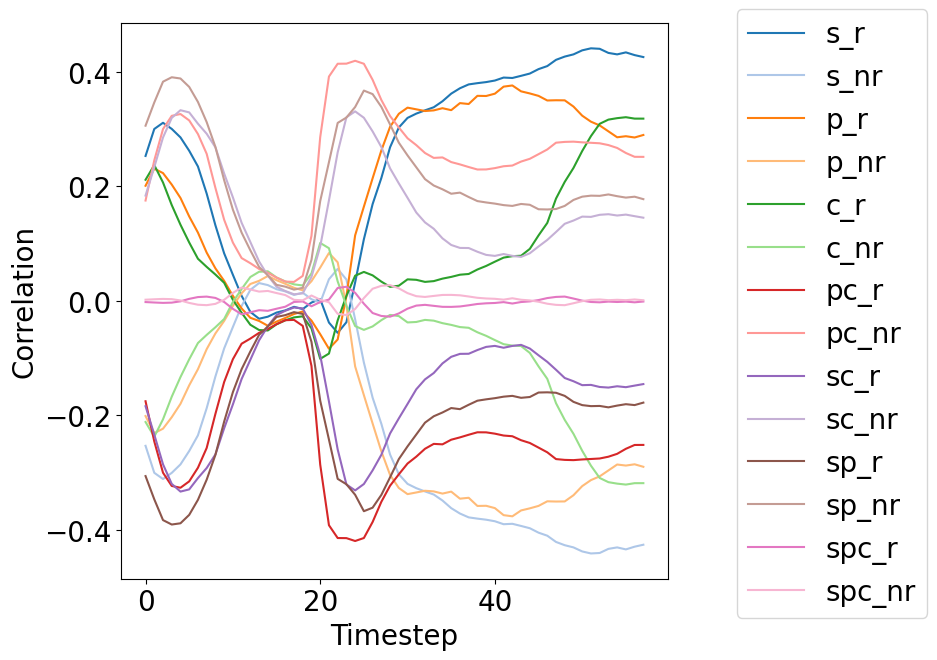

In [30]:
import matplotlib as mpl

for ft_idx, ft_key in enumerate(['s','p','c']):
    avg_corr = np.zeros((2, num_timesteps,))
    for ft in range(3):
        avg_corr[0] += batch_cosine_similarity(dpca_out.marginalized_psth[ft_key].squeeze()[:,ft][None],
                                dpca_results_by_prev[1]['marginalized_psth']['tr'+ft_key].squeeze()[:,:,0,ft].T).squeeze()
        avg_corr[1] += batch_cosine_similarity(dpca_out.marginalized_psth[ft_key].squeeze()[:,ft][None],
                                dpca_results_by_prev[1]['marginalized_psth']['tr'+ft_key].squeeze()[:,:,1,ft].T).squeeze()
    plt.plot(avg_corr[1]/3, label=ft_key+'_r', color=mpl.colormaps["tab20"](ft_idx*2))
    plt.plot(avg_corr[0]/3, label=ft_key+'_nr', color=mpl.colormaps["tab20"](ft_idx*2+1))

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_corr = np.zeros((2,num_timesteps,))
    for ft1 in range(3):
        for ft2 in range(3):
            avg_corr[0] += batch_cosine_similarity(dpca_out.marginalized_psth[conj_key].squeeze()[:,ft1,ft2][None],
                                    dpca_results_by_prev[1]['marginalized_psth']['tr'+conj_key].squeeze()[:,:,0,ft1,ft2].T).squeeze()
            avg_corr[1] += batch_cosine_similarity(dpca_out.marginalized_psth[conj_key].squeeze()[:,ft1,ft2][None],
                                    dpca_results_by_prev[1]['marginalized_psth']['tr'+conj_key].squeeze()[:,:,1,ft1,ft2].T).squeeze()
    plt.plot(avg_corr[1]/9, label=conj_key+'_r', color=mpl.colormaps["tab20"](6+conj_idx*2))
    plt.plot(avg_corr[0]/9, label=conj_key+'_nr', color=mpl.colormaps["tab20"](6+conj_idx*2+1))
    
avg_corr = np.zeros((2,num_timesteps,))
for ft1 in range(3):
    for ft2 in range(3):
        for ft3 in range(3):
            avg_corr[0] += batch_cosine_similarity(dpca_in.marginalized_psth[conj_key].squeeze()[:,ft1,ft2][None],
                                    dpca_results_by_prev[1]['marginalized_psth']['trspc'].squeeze()[:,:,0,ft1,ft2,ft3].T).squeeze()
            avg_corr[1] += batch_cosine_similarity(dpca_in.marginalized_psth[conj_key].squeeze()[:,ft1,ft2][None],
                                    dpca_results_by_prev[1]['marginalized_psth']['trspc'].squeeze()[:,:,1,ft1,ft2,ft3].T).squeeze()
plt.plot(avg_corr[1]/9, label='spc_r', color=mpl.colormaps["tab20"](12))
plt.plot(avg_corr[0]/9, label='spc_nr', color=mpl.colormaps["tab20"](13))

plt.xlabel('Timestep')
plt.ylabel('Correlation')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()

In [46]:
np.mean(task_mdprl.prob_mdprl, axis=(1,))

array([[[0.66333333, 0.22666667, 0.66333333],
        [0.5       , 0.5       , 0.5       ],
        [0.33666667, 0.77333333, 0.33666667]]])

In [47]:
np.stack([task_mdprl.index_shp, task_mdprl.index_clr, task_mdprl.index_pttrn])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2],
       [0, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0, 0, 1,
        1, 1, 2, 2, 2],
       [0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0,
        1, 2, 0, 1, 2]])

# Analysis of Naive Weights of RNN

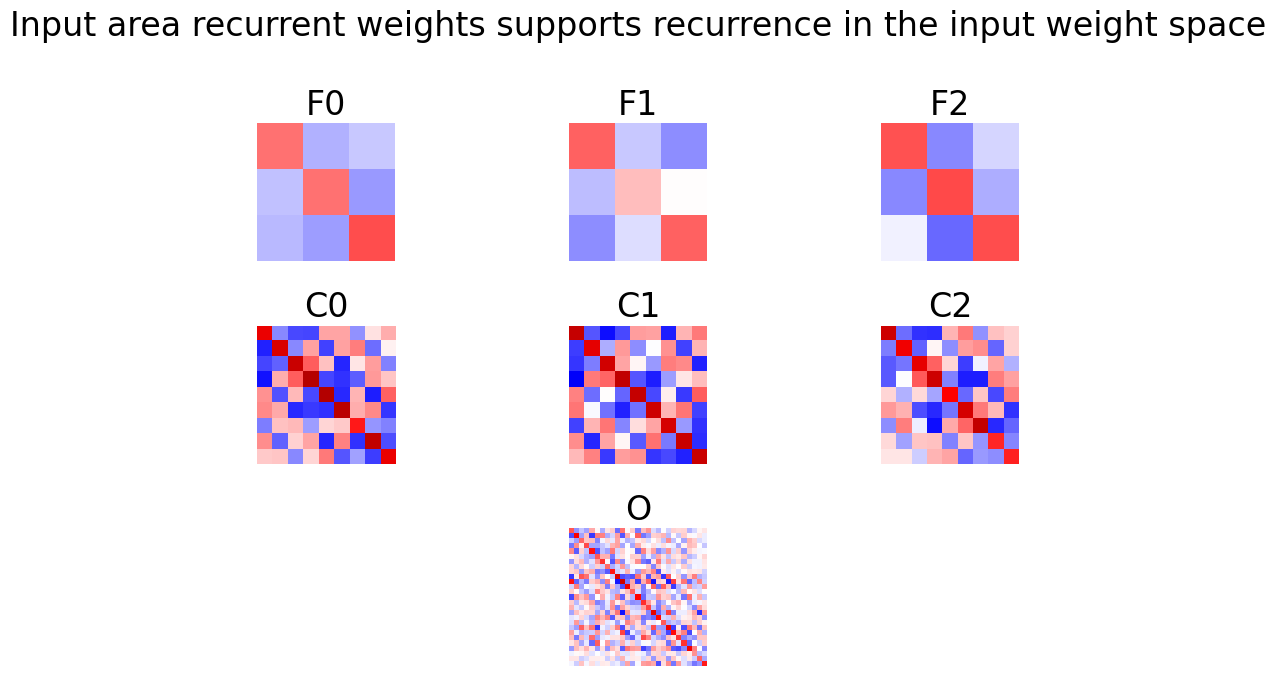

In [24]:
# Aligning recurrent weights in area 1 with input weights

from sklearn.metrics.pairwise import cosine_similarity

fig, axes = plt.subplots(3, 3)


for ft_idx, ft_key in enumerate(['s','p','c']):
    avg_corr = np.zeros((3, 3))
    axes[0, ft_idx].imshow(cosine_similarity(
                    (rec_intra[0]@dpca_in.marginalized_psth[ft_key].squeeze().reshape(-1, 3)).T,\
                    dpca_in.marginalized_psth[ft_key].squeeze().reshape(-1, 3).T),
                    vmin=-1, vmax=1, cmap='seismic')
    axes[0, ft_idx].axis('off')
    axes[0, ft_idx].set_title('F'+str(ft_idx))

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_corr = np.zeros((9, 9))
    axes[1, conj_idx].imshow(cosine_similarity(
                    (rec_intra[0]@dpca_in.marginalized_psth[conj_key].squeeze().reshape(-1, 9)).T,\
                    dpca_in.marginalized_psth[conj_key].squeeze().reshape(-1, 9).T),
                    vmin=-1, vmax=1, cmap='seismic')
    axes[1, conj_idx].axis('off')
    axes[1, conj_idx].set_title('C'+str(conj_idx))

axes[2, 1].imshow(cosine_similarity(
                (rec_intra[0]@dpca_in.marginalized_psth['spc'].squeeze().reshape(-1, 27)).T,\
                dpca_in.marginalized_psth['spc'].squeeze().reshape(-1, 27).T),
                vmin=-1, vmax=1, cmap='seismic')
axes[2, 1].set_title('O')
for i in range(3):
    axes[2, i].axis('off')

fig.suptitle("Input area recurrent weights supports recurrence in the input weight space")
plt.tight_layout()

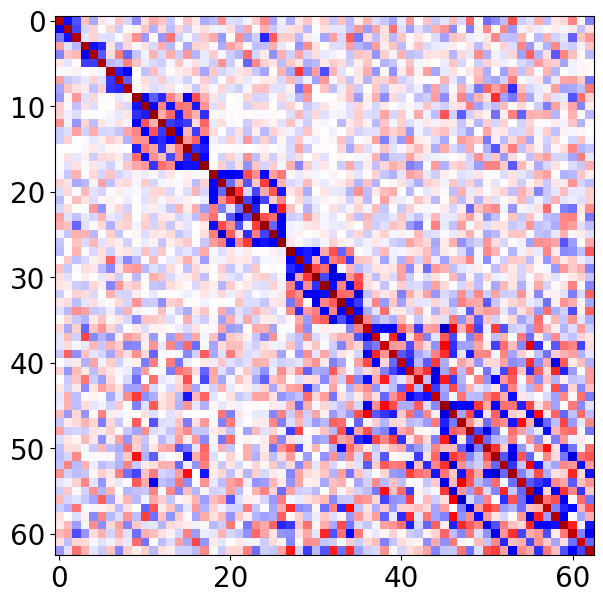

In [25]:
plt.imshow(cosine_similarity((rec_inter_ff[0]@all_dpca_psth_in).T, all_dpca_psth_out.T),
          vmin=-1, vmax=1, cmap='seismic')

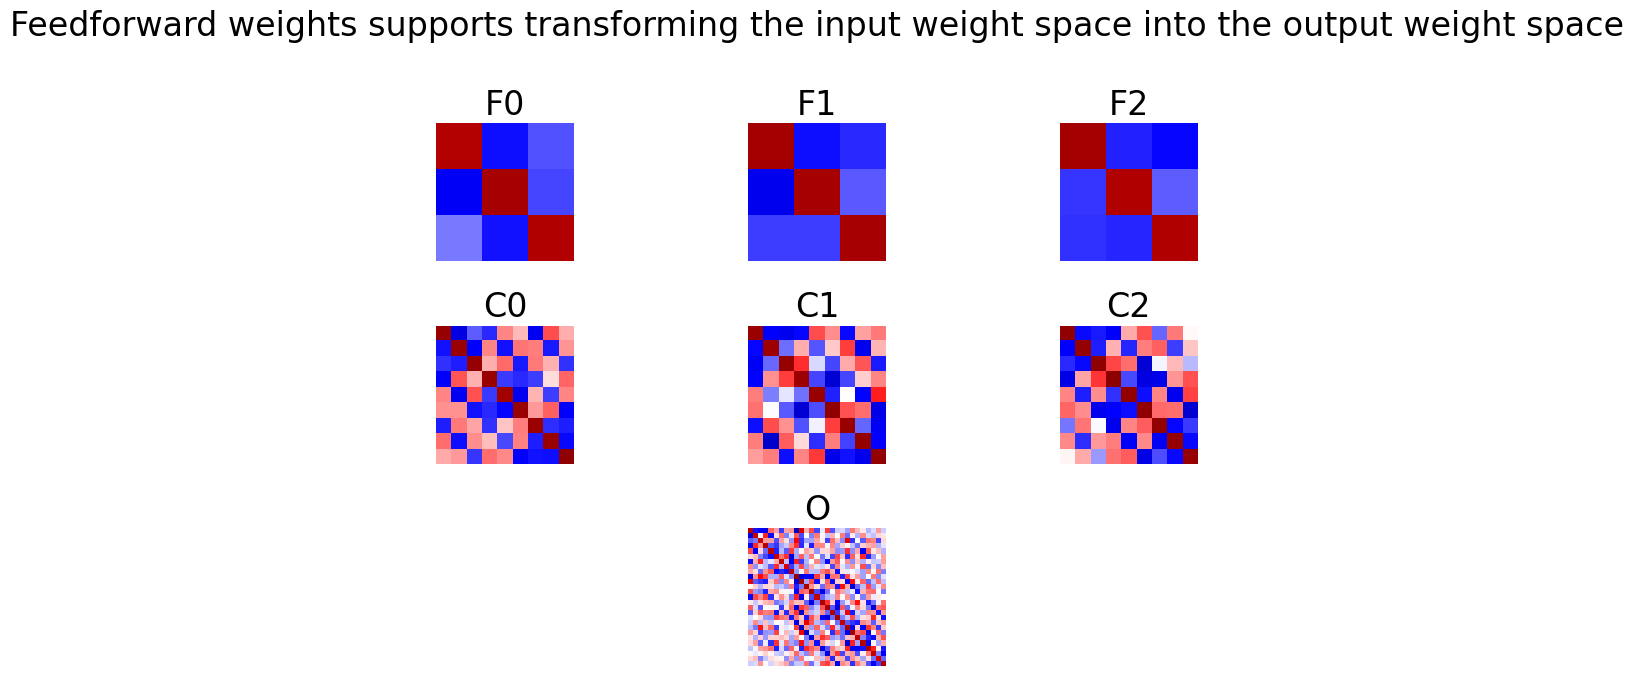

In [26]:
import matplotlib as mpl

fig, axes = plt.subplots(3, 3)

for ft_idx, ft_key in enumerate(['s','p','c']):
    avg_corr = np.zeros((3, 3))
    axes[0, ft_idx].imshow(cosine_similarity(
                    (rec_inter_ff[0]@dpca_in.marginalized_psth[ft_key].squeeze().reshape(-1, 3)).T,\
                    dpca_out.marginalized_psth[ft_key].squeeze().reshape(-1, 3).T),
                    vmin=-1, vmax=1, cmap='seismic')
    axes[0, ft_idx].axis('off')
    axes[0, ft_idx].set_title('F'+str(ft_idx))

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_corr = np.zeros((9, 9))
    axes[1, conj_idx].imshow(cosine_similarity(
                    (rec_inter_ff[0]@dpca_in.marginalized_psth[conj_key].squeeze().reshape(-1, 9)).T,\
                    dpca_out.marginalized_psth[conj_key].squeeze().reshape(-1, 9).T),
                    vmin=-1, vmax=1, cmap='seismic')
    axes[1, conj_idx].axis('off')
    axes[1, conj_idx].set_title('C'+str(conj_idx))

axes[2, 1].imshow(cosine_similarity(
                (rec_inter_ff[0]@dpca_in.marginalized_psth['spc'].squeeze().reshape(-1, 27)).T,\
                dpca_out.marginalized_psth['spc'].squeeze().reshape(-1, 27).T),
                vmin=-1, vmax=1, cmap='seismic')
axes[2, 1].set_title('O')
for i in range(3):
    axes[2, i].axis('off')

fig.suptitle("Feedforward weights supports transforming the input weight space into the output weight space")
plt.tight_layout()

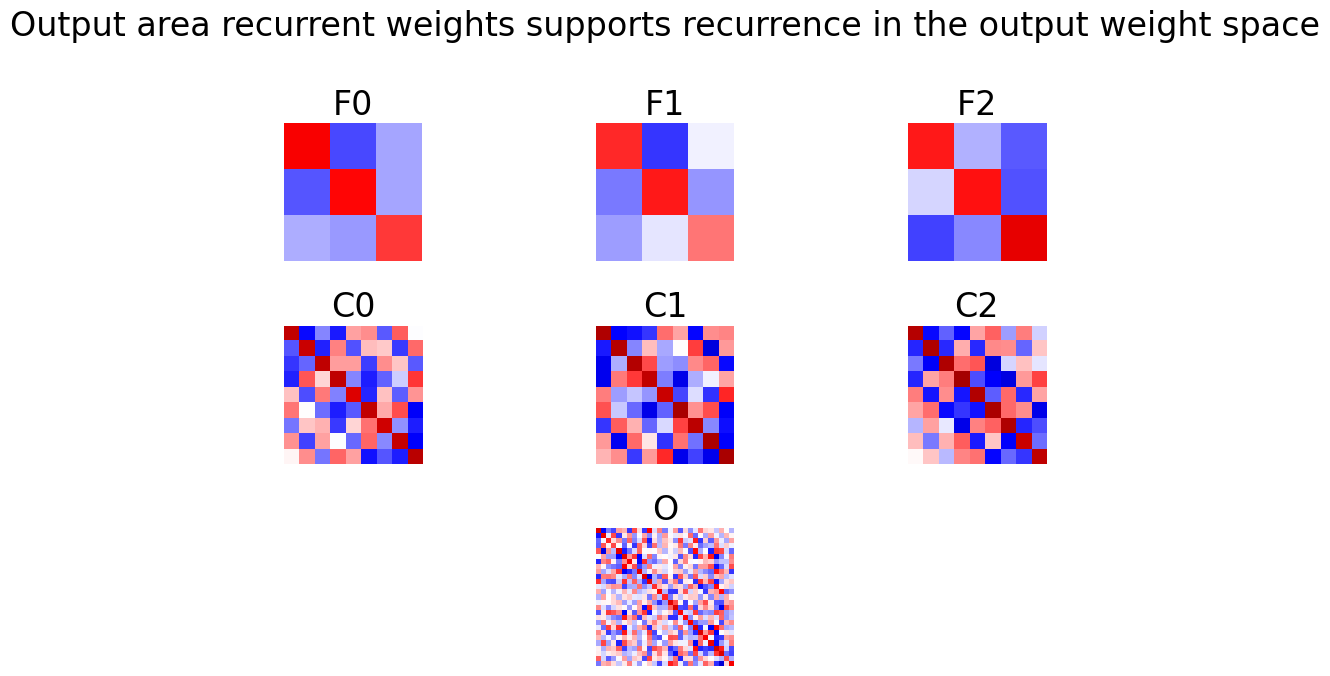

In [27]:
import matplotlib as mpl

fig, axes = plt.subplots(3, 3)

for ft_idx, ft_key in enumerate(['s','p','c']):
    avg_corr = np.zeros((3, 3))
    axes[0, ft_idx].imshow(cosine_similarity(
                    (rec_intra[1]@dpca_out.marginalized_psth[ft_key].squeeze().reshape(-1, 3)).T,\
                    dpca_out.marginalized_psth[ft_key].squeeze().reshape(-1, 3).T),
                    vmin=-1, vmax=1, cmap='seismic')
    axes[0, ft_idx].axis('off')
    axes[0, ft_idx].set_title('F'+str(ft_idx))

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_corr = np.zeros((9, 9))
    axes[1, conj_idx].imshow(cosine_similarity(
                    (rec_intra[1]@dpca_out.marginalized_psth[conj_key].squeeze().reshape(-1, 9)).T,\
                    dpca_out.marginalized_psth[conj_key].squeeze().reshape(-1, 9).T),
                    vmin=-1, vmax=1, cmap='seismic')
    axes[1, conj_idx].axis('off')
    axes[1, conj_idx].set_title('C'+str(conj_idx))

axes[2, 1].imshow(cosine_similarity(
                (rec_intra[1]@dpca_out.marginalized_psth['spc'].squeeze().reshape(-1, 27)).T,\
                dpca_out.marginalized_psth['spc'].squeeze().reshape(-1, 27).T),
                vmin=-1, vmax=1, cmap='seismic')
axes[2, 1].set_title('O')
for i in range(3):
    axes[2, i].axis('off')

fig.suptitle("Output area recurrent weights supports recurrence in the output weight space")
plt.tight_layout()

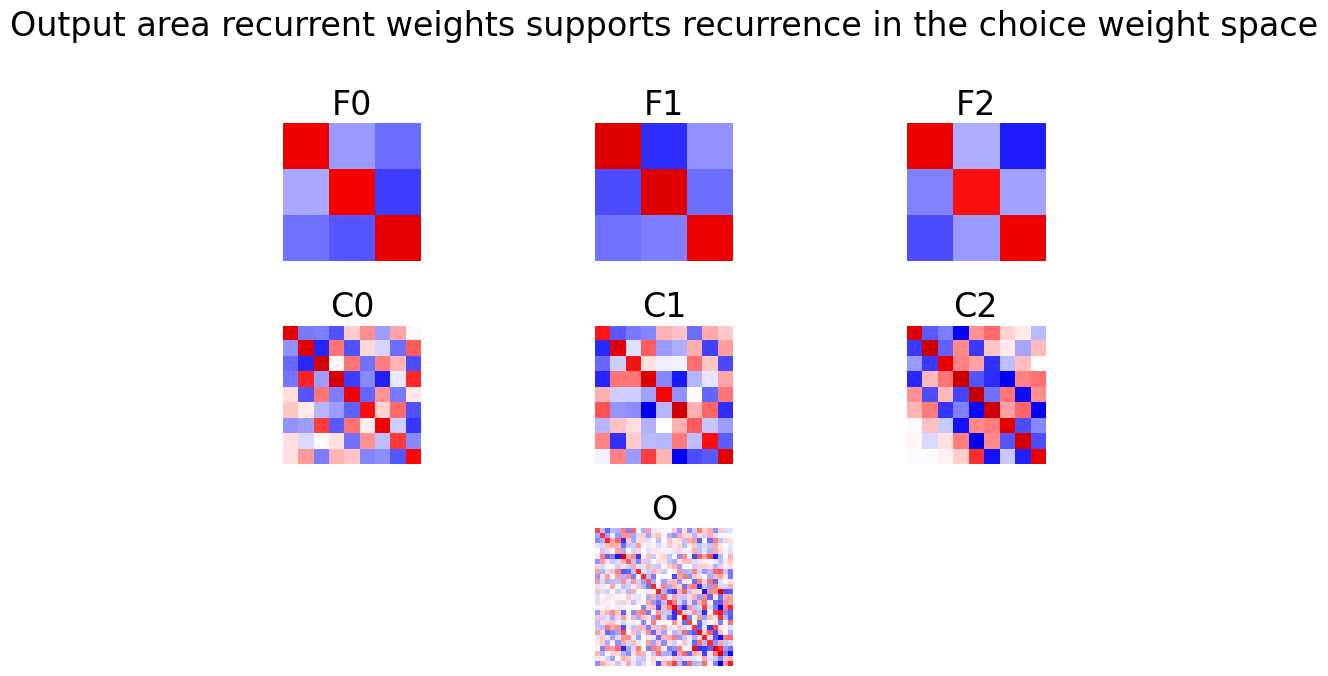

In [28]:
import matplotlib as mpl

fig, axes = plt.subplots(3, 3)

for ft_idx, ft_key in enumerate(['s','p','c']):
    avg_corr = np.zeros((3, 3))
    axes[0, ft_idx].imshow(cosine_similarity(
                    (rec_intra[1]@dpca_ch.marginalized_psth[ft_key].squeeze().reshape(-1, 3)).T,\
                    dpca_ch.marginalized_psth[ft_key].squeeze().reshape(-1, 3).T),
                    vmin=-1, vmax=1, cmap='seismic')
    axes[0, ft_idx].axis('off')
    axes[0, ft_idx].set_title('F'+str(ft_idx))

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_corr = np.zeros((9, 9))
    axes[1, conj_idx].imshow(cosine_similarity(
                    (rec_intra[1]@dpca_ch.marginalized_psth[conj_key].squeeze().reshape(-1, 9)).T,\
                    dpca_ch.marginalized_psth[conj_key].squeeze().reshape(-1, 9).T),
                    vmin=-1, vmax=1, cmap='seismic')
    axes[1, conj_idx].axis('off')
    axes[1, conj_idx].set_title('C'+str(conj_idx))

axes[2, 1].imshow(cosine_similarity(
                (rec_intra[1]@dpca_ch.marginalized_psth['spc'].squeeze().reshape(-1, 27)).T,\
                dpca_ch.marginalized_psth['spc'].squeeze().reshape(-1, 27).T),
                vmin=-1, vmax=1, cmap='seismic')
axes[2, 1].set_title('O')
for i in range(3):
    axes[2, i].axis('off')

fig.suptitle("Output area recurrent weights supports recurrence in the choice weight space")
plt.tight_layout()

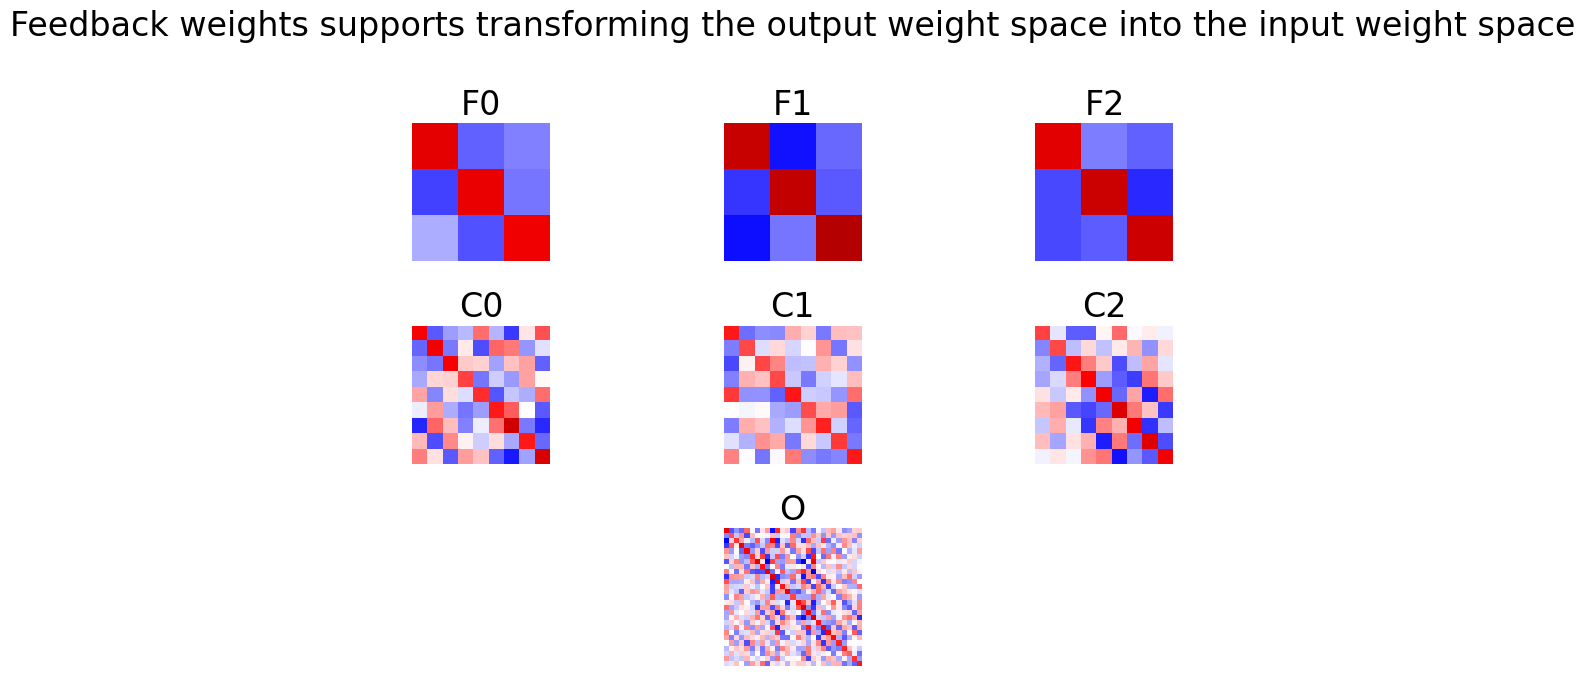

In [29]:
import matplotlib as mpl

fig, axes = plt.subplots(3, 3)

for ft_idx, ft_key in enumerate(['s','p','c']):
    avg_corr = np.zeros((3, 3))
    axes[0, ft_idx].imshow(cosine_similarity(
                    (rec_inter_fb[0]@dpca_out.marginalized_psth[ft_key].squeeze().reshape(-1, 3)).T,\
                    dpca_in.marginalized_psth[ft_key].squeeze().reshape(-1, 3).T),
                    vmin=-1, vmax=1, cmap='seismic')
    axes[0, ft_idx].axis('off')
    axes[0, ft_idx].set_title('F'+str(ft_idx))

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_corr = np.zeros((9, 9))
    axes[1, conj_idx].imshow(cosine_similarity(
                    (rec_inter_fb[0]@dpca_out.marginalized_psth[conj_key].squeeze().reshape(-1, 9)).T,\
                    dpca_in.marginalized_psth[conj_key].squeeze().reshape(-1, 9).T),
                    vmin=-1, vmax=1, cmap='seismic')
    axes[1, conj_idx].axis('off')
    axes[1, conj_idx].set_title('C'+str(conj_idx))

axes[2, 1].imshow(cosine_similarity(
                (rec_inter_fb[0]@dpca_out.marginalized_psth['spc'].squeeze().reshape(-1, 27)).T,\
                dpca_in.marginalized_psth['spc'].squeeze().reshape(-1, 27).T),
                vmin=-1, vmax=1, cmap='seismic')
axes[2, 1].set_title('O')
for i in range(3):
    axes[2, i].axis('off')

fig.suptitle("Feedback weights supports transforming the output weight space into the input weight space")
plt.tight_layout()

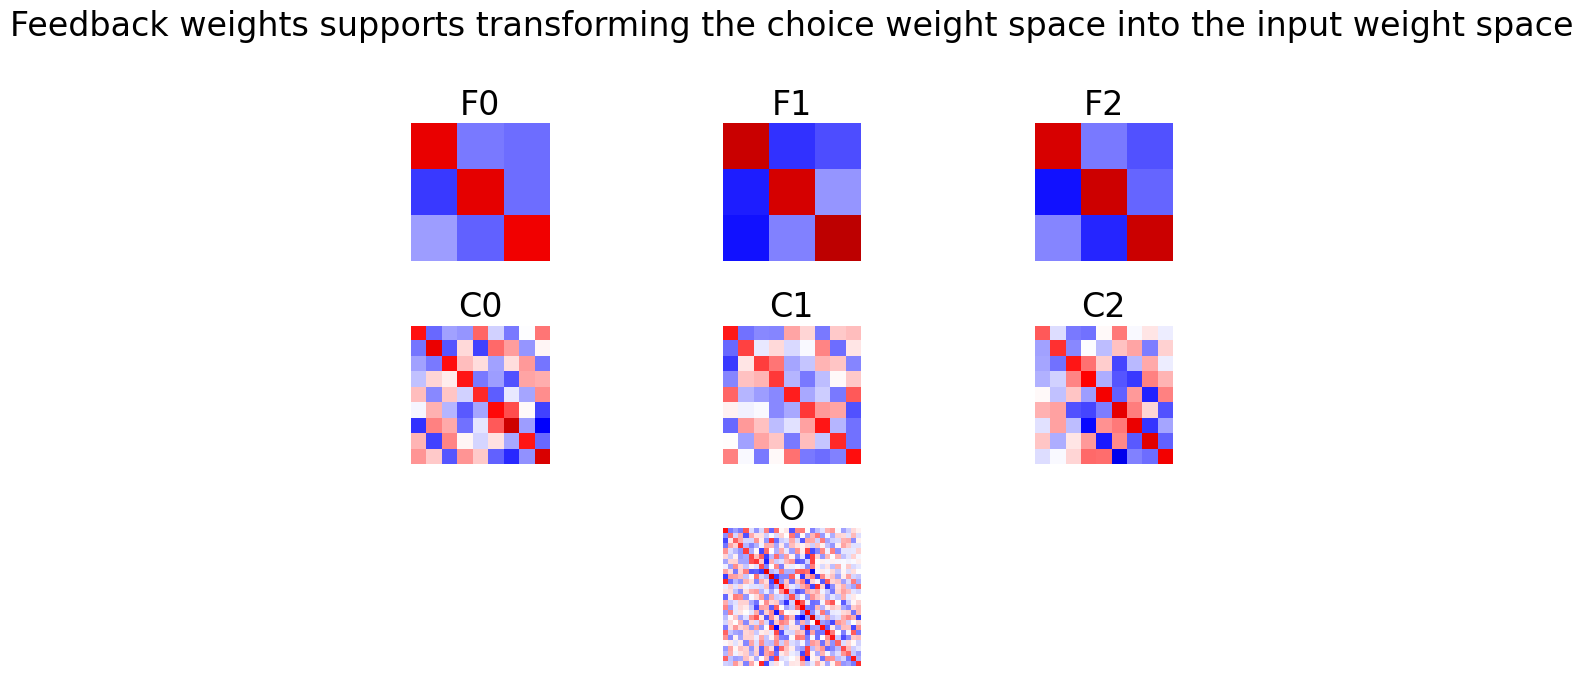

In [30]:
import matplotlib as mpl

fig, axes = plt.subplots(3, 3)

for ft_idx, ft_key in enumerate(['s','p','c']):
    avg_corr = np.zeros((3, 3))
    axes[0, ft_idx].imshow(cosine_similarity(
                    (rec_inter_fb[0]@dpca_ch.marginalized_psth[ft_key].squeeze().reshape(-1, 3)).T,\
                    dpca_in.marginalized_psth[ft_key].squeeze().reshape(-1, 3).T),
                    vmin=-1, vmax=1, cmap='seismic')
    axes[0, ft_idx].axis('off')
    axes[0, ft_idx].set_title('F'+str(ft_idx))

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_corr = np.zeros((9, 9))
    axes[1, conj_idx].imshow(cosine_similarity(
                    (rec_inter_fb[0]@dpca_ch.marginalized_psth[conj_key].squeeze().reshape(-1, 9)).T,\
                    dpca_in.marginalized_psth[conj_key].squeeze().reshape(-1, 9).T),
                    vmin=-1, vmax=1, cmap='seismic')
    axes[1, conj_idx].axis('off')
    axes[1, conj_idx].set_title('C'+str(conj_idx))

axes[2, 1].imshow(cosine_similarity(
                (rec_inter_fb[0]@dpca_ch.marginalized_psth['spc'].squeeze().reshape(-1, 27)).T,\
                dpca_in.marginalized_psth['spc'].squeeze().reshape(-1, 27).T),
                vmin=-1, vmax=1, cmap='seismic')
axes[2, 1].set_title('O')
for i in range(3):
    axes[2, i].axis('off')

fig.suptitle("Feedback weights supports transforming the choice weight space into the input weight space")
plt.tight_layout()

# Analysis of learning rate matrix of the recurrent weights

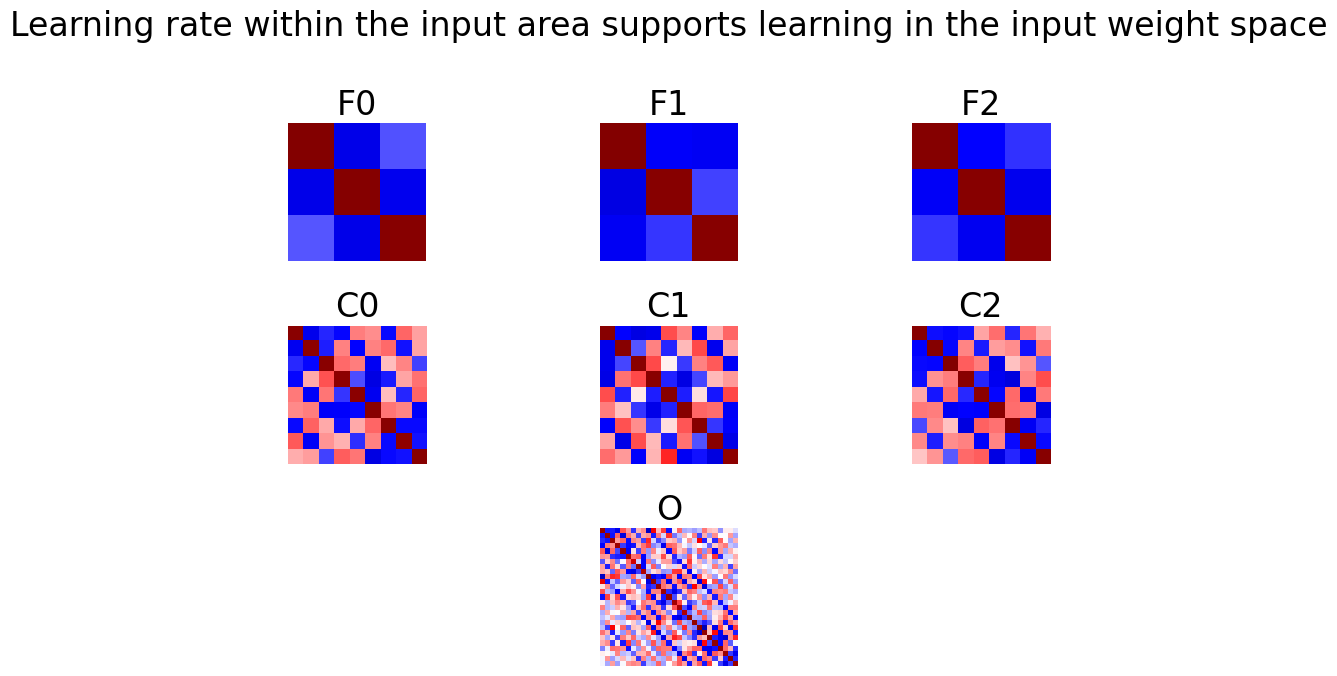

In [31]:
import matplotlib as mpl

fig, axes = plt.subplots(3, 3)

for ft_idx, ft_key in enumerate(['s','p','c']):
    avg_corr = np.zeros((3, 3))
    for ft1_val in range(3):
        for ft2_val in range(3):
            avg_corr[ft1_val, ft2_val] = cosine_similarity(((kappa_rec_intra[0]*\
                        np.outer(dpca_in.marginalized_psth[ft_key].squeeze().reshape(-1, 3)[:,ft1_val], \
                                 dpca_in.marginalized_psth[ft_key].squeeze().reshape(-1, 3)[:,ft1_val])) @
                                 dpca_in.marginalized_psth[ft_key].squeeze().reshape(-1, 3)[:,ft1_val][:,None]).T, 
                        dpca_in.marginalized_psth[ft_key].squeeze().reshape(-1, 3)[:,ft2_val][None,:])
    axes[0, ft_idx].imshow(avg_corr, vmin=-1, vmax=1, cmap='seismic')
    axes[0, ft_idx].axis('off')
    axes[0, ft_idx].set_title('F'+str(ft_idx))

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_corr = np.zeros((9, 9))
    for conj1_val in range(9):
        for conj2_val in range(9):
            avg_corr[conj1_val, conj2_val] = cosine_similarity(((kappa_rec_intra[0]*\
                        np.outer(dpca_in.marginalized_psth[conj_key].squeeze().reshape(-1, 9)[:,conj1_val], \
                                 dpca_in.marginalized_psth[conj_key].squeeze().reshape(-1, 9)[:,conj1_val])) @
                                 dpca_in.marginalized_psth[conj_key].squeeze().reshape(-1, 9)[:,conj1_val][:,None]).T, 
                        dpca_in.marginalized_psth[conj_key].squeeze().reshape(-1, 9)[:,conj2_val][None,:])
    axes[1, conj_idx].imshow(avg_corr, vmin=-1, vmax=1, cmap='seismic')
    axes[1, conj_idx].axis('off')
    axes[1, conj_idx].set_title('C'+str(conj_idx))

avg_corr = np.zeros((27,27))
for obj1_val in range(27):
    for obj2_val in range(27):
        avg_corr[obj1_val, obj2_val] = cosine_similarity(((kappa_rec_intra[0]*\
                        np.outer(dpca_in.marginalized_psth["spc"].squeeze().reshape(-1, 27)[:,obj1_val], \
                                 dpca_in.marginalized_psth["spc"].squeeze().reshape(-1, 27)[:,obj1_val])) @
                                 dpca_in.marginalized_psth["spc"].squeeze().reshape(-1, 27)[:,obj1_val][:,None]).T, 
                        dpca_in.marginalized_psth["spc"].squeeze().reshape(-1, 27)[:,obj2_val][None,:])
axes[2, 1].imshow(avg_corr, vmin=-1, vmax=1, cmap='seismic')
axes[2, 1].set_title('O')
for i in range(3):
    axes[2, i].axis('off')

fig.suptitle("Learning rate within the input area supports learning in the input weight space")
plt.tight_layout()


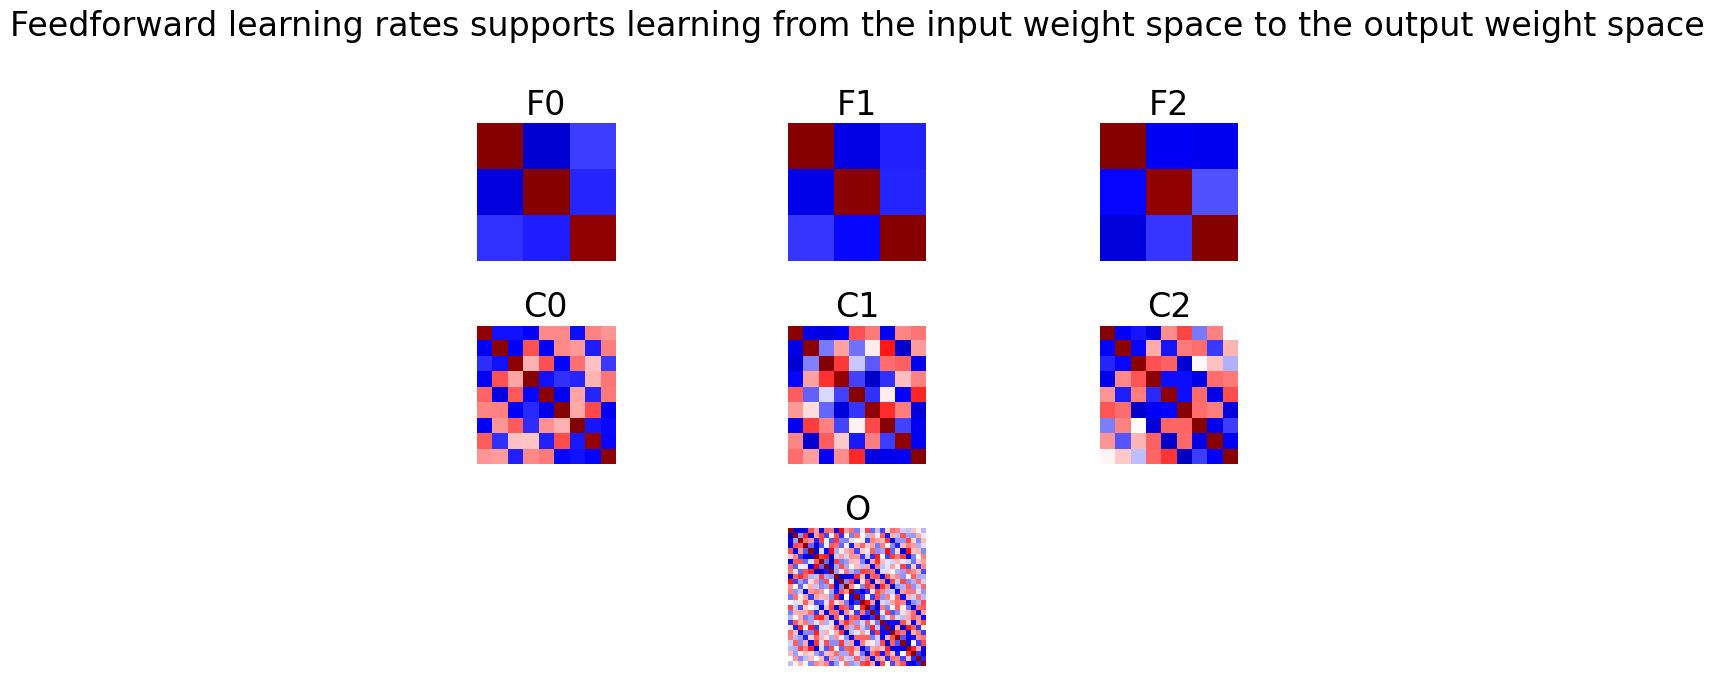

In [32]:
import matplotlib as mpl

fig, axes = plt.subplots(3, 3)

for ft_idx, ft_key in enumerate(['s','p','c']):
    avg_corr = np.zeros((3, 3))
    for ft1_val in range(3):
        for ft2_val in range(3):
            avg_corr[ft1_val, ft2_val] = cosine_similarity(((kappa_inter_ff[0]*\
                        np.outer(dpca_out.marginalized_psth[ft_key].squeeze().reshape(-1, 3)[:,ft1_val], \
                                 dpca_in.marginalized_psth[ft_key].squeeze().reshape(-1, 3)[:,ft1_val])) @
                                 dpca_in.marginalized_psth[ft_key].squeeze().reshape(-1, 3)[:,ft1_val][:,None]).T, 
                        dpca_out.marginalized_psth[ft_key].squeeze().reshape(-1, 3)[:,ft2_val][None,:])
    axes[0, ft_idx].imshow(avg_corr, vmin=-1, vmax=1, cmap='seismic')
    axes[0, ft_idx].axis('off')
    axes[0, ft_idx].set_title('F'+str(ft_idx))

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_corr = np.zeros((9, 9))
    for conj1_val in range(9):
        for conj2_val in range(9):
            avg_corr[conj1_val, conj2_val] = cosine_similarity(((kappa_inter_ff[0]*\
                        np.outer(dpca_out.marginalized_psth[conj_key].squeeze().reshape(-1, 9)[:,conj1_val], \
                                 dpca_in.marginalized_psth[conj_key].squeeze().reshape(-1, 9)[:,conj1_val])) @
                                 dpca_in.marginalized_psth[conj_key].squeeze().reshape(-1, 9)[:,conj1_val][:,None]).T, 
                        dpca_out.marginalized_psth[conj_key].squeeze().reshape(-1, 9)[:,conj2_val][None,:])
    axes[1, conj_idx].imshow(avg_corr, vmin=-1, vmax=1, cmap='seismic')
    axes[1, conj_idx].axis('off')
    axes[1, conj_idx].set_title('C'+str(conj_idx))

avg_corr = np.zeros((27,27))
for obj1_val in range(27):
    for obj2_val in range(27):
        avg_corr[obj1_val, obj2_val] = cosine_similarity(((kappa_inter_ff[0]*\
                        np.outer(dpca_out.marginalized_psth["spc"].squeeze().reshape(-1, 27)[:,obj1_val], \
                                 dpca_in.marginalized_psth["spc"].squeeze().reshape(-1, 27)[:,obj1_val])) @
                                 dpca_in.marginalized_psth["spc"].squeeze().reshape(-1, 27)[:,obj1_val][:,None]).T, 
                        dpca_out.marginalized_psth["spc"].squeeze().reshape(-1, 27)[:,obj2_val][None,:])
axes[2, 1].imshow(avg_corr, vmin=-1, vmax=1, cmap='seismic')
axes[2, 1].set_title('O')
for i in range(3):
    axes[2, i].axis('off')

fig.suptitle("Feedforward learning rates supports learning from the input weight space to the output weight space")
plt.tight_layout()


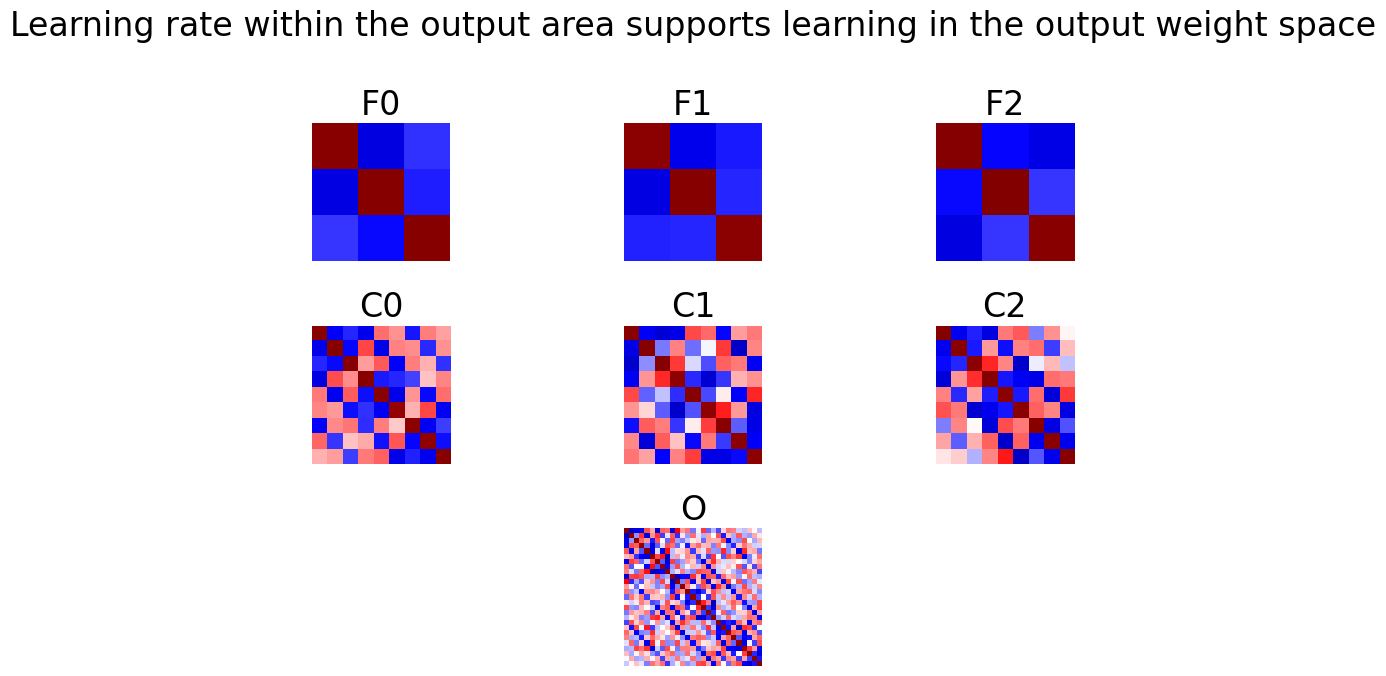

In [33]:
import matplotlib as mpl

fig, axes = plt.subplots(3, 3)

for ft_idx, ft_key in enumerate(['s','p','c']):
    avg_corr = np.zeros((3, 3))
    for ft1_val in range(3):
        for ft2_val in range(3):
            avg_corr[ft1_val, ft2_val] = cosine_similarity(((kappa_rec_intra[1]*\
                        np.outer(dpca_out.marginalized_psth[ft_key].squeeze().reshape(-1, 3)[:,ft1_val], \
                                 dpca_out.marginalized_psth[ft_key].squeeze().reshape(-1, 3)[:,ft1_val])) @
                                 dpca_out.marginalized_psth[ft_key].squeeze().reshape(-1, 3)[:,ft1_val][:,None]).T, 
                        dpca_out.marginalized_psth[ft_key].squeeze().reshape(-1, 3)[:,ft2_val][None,:])
    axes[0, ft_idx].imshow(avg_corr, vmin=-1, vmax=1, cmap='seismic')
    axes[0, ft_idx].axis('off')
    axes[0, ft_idx].set_title('F'+str(ft_idx))

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_corr = np.zeros((9, 9))
    for conj1_val in range(9):
        for conj2_val in range(9):
            avg_corr[conj1_val, conj2_val] = cosine_similarity(((kappa_rec_intra[1]*\
                        np.outer(dpca_out.marginalized_psth[conj_key].squeeze().reshape(-1, 9)[:,conj1_val], \
                                 dpca_out.marginalized_psth[conj_key].squeeze().reshape(-1, 9)[:,conj1_val])) @
                                 dpca_out.marginalized_psth[conj_key].squeeze().reshape(-1, 9)[:,conj1_val][:,None]).T, 
                        dpca_out.marginalized_psth[conj_key].squeeze().reshape(-1, 9)[:,conj2_val][None,:])
    axes[1, conj_idx].imshow(avg_corr, vmin=-1, vmax=1, cmap='seismic')
    axes[1, conj_idx].axis('off')
    axes[1, conj_idx].set_title('C'+str(conj_idx))

avg_corr = np.zeros((27,27))
for obj1_val in range(27):
    for obj2_val in range(27):
        avg_corr[obj1_val, obj2_val] = cosine_similarity(((kappa_rec_intra[1]*\
                        np.outer(dpca_out.marginalized_psth["spc"].squeeze().reshape(-1, 27)[:,obj1_val], \
                                 dpca_out.marginalized_psth["spc"].squeeze().reshape(-1, 27)[:,obj1_val])) @
                                 dpca_out.marginalized_psth["spc"].squeeze().reshape(-1, 27)[:,obj1_val][:,None]).T, 
                        dpca_out.marginalized_psth["spc"].squeeze().reshape(-1, 27)[:,obj2_val][None,:])
axes[2, 1].imshow(avg_corr, vmin=-1, vmax=1, cmap='seismic')
axes[2, 1].set_title('O')
for i in range(3):
    axes[2, i].axis('off')

fig.suptitle("Learning rate within the output area supports learning in the output weight space")
plt.tight_layout()


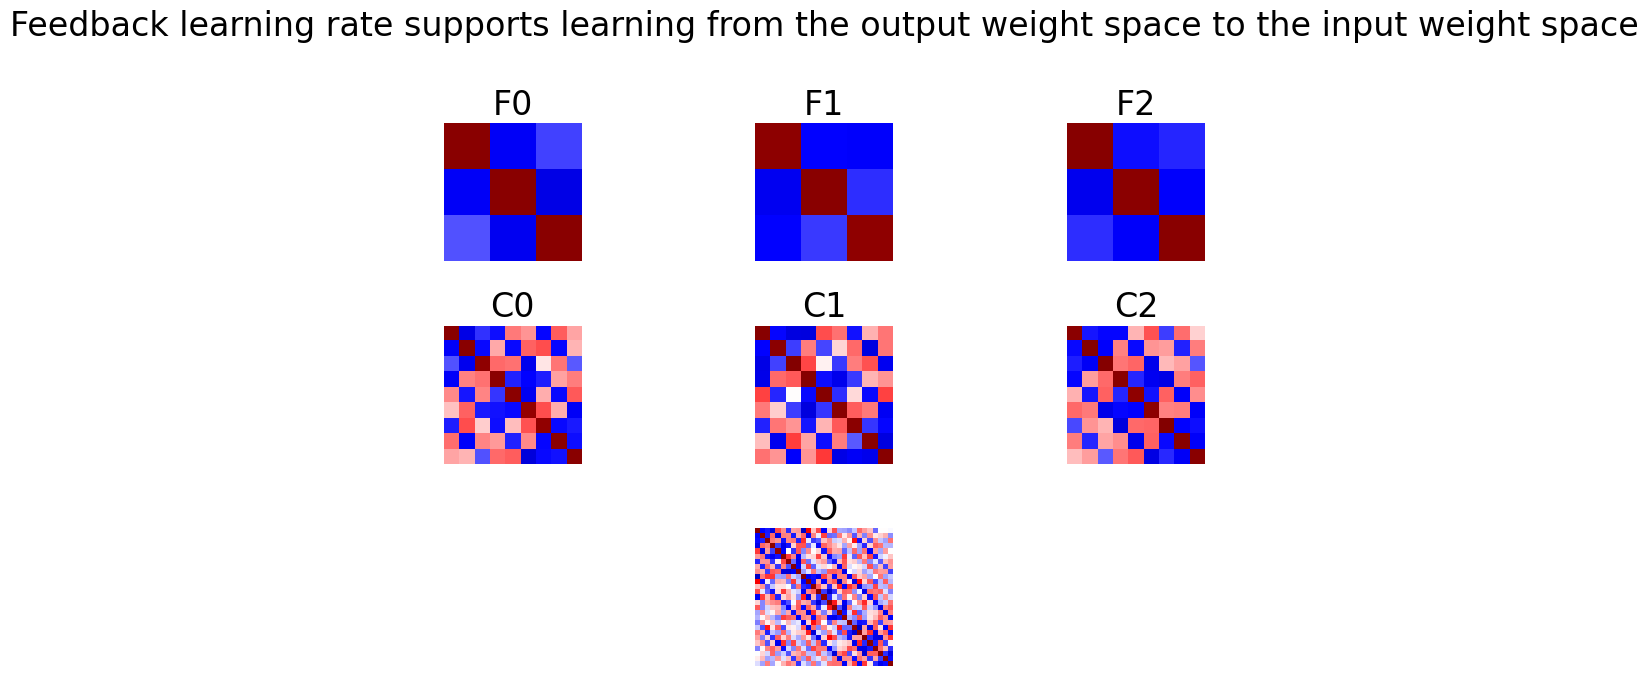

In [34]:
import matplotlib as mpl

fig, axes = plt.subplots(3, 3)

for ft_idx, ft_key in enumerate(['s','p','c']):
    avg_corr = np.zeros((3, 3))
    for ft1_val in range(3):
        for ft2_val in range(3):
            avg_corr[ft1_val, ft2_val] = cosine_similarity(((kappa_inter_fb[0]*\
                        np.outer(dpca_in.marginalized_psth[ft_key].squeeze().reshape(-1, 3)[:,ft1_val], \
                                 dpca_out.marginalized_psth[ft_key].squeeze().reshape(-1, 3)[:,ft1_val])) @
                                 dpca_out.marginalized_psth[ft_key].squeeze().reshape(-1, 3)[:,ft1_val][:,None]).T, 
                        dpca_in.marginalized_psth[ft_key].squeeze().reshape(-1, 3)[:,ft2_val][None,:])
    axes[0, ft_idx].imshow(avg_corr, vmin=-1, vmax=1, cmap='seismic')
    axes[0, ft_idx].axis('off')
    axes[0, ft_idx].set_title('F'+str(ft_idx))

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_corr = np.zeros((9, 9))
    for conj1_val in range(9):
        for conj2_val in range(9):
            avg_corr[conj1_val, conj2_val] = cosine_similarity(((kappa_inter_fb[0]*\
                        np.outer(dpca_in.marginalized_psth[conj_key].squeeze().reshape(-1, 9)[:,conj1_val], \
                                 dpca_out.marginalized_psth[conj_key].squeeze().reshape(-1, 9)[:,conj1_val])) @
                                 dpca_out.marginalized_psth[conj_key].squeeze().reshape(-1, 9)[:,conj1_val][:,None]).T, 
                        dpca_in.marginalized_psth[conj_key].squeeze().reshape(-1, 9)[:,conj2_val][None,:])
    axes[1, conj_idx].imshow(avg_corr, vmin=-1, vmax=1, cmap='seismic')
    axes[1, conj_idx].axis('off')
    axes[1, conj_idx].set_title('C'+str(conj_idx))

avg_corr = np.zeros((27,27))
for obj1_val in range(27):
    for obj2_val in range(27):
        avg_corr[obj1_val, obj2_val] = cosine_similarity(((kappa_inter_fb[0]*\
                        np.outer(dpca_in.marginalized_psth["spc"].squeeze().reshape(-1, 27)[:,obj1_val], \
                                 dpca_out.marginalized_psth["spc"].squeeze().reshape(-1, 27)[:,obj1_val])) @
                                 dpca_out.marginalized_psth["spc"].squeeze().reshape(-1, 27)[:,obj1_val][:,None]).T, 
                        dpca_in.marginalized_psth["spc"].squeeze().reshape(-1, 27)[:,obj2_val][None,:])
axes[2, 1].imshow(avg_corr, vmin=-1, vmax=1, cmap='seismic')
axes[2, 1].set_title('O')
for i in range(3):
    axes[2, i].axis('off')

fig.suptitle("Feedback learning rate supports learning from the output weight space to the input weight space")
plt.tight_layout()


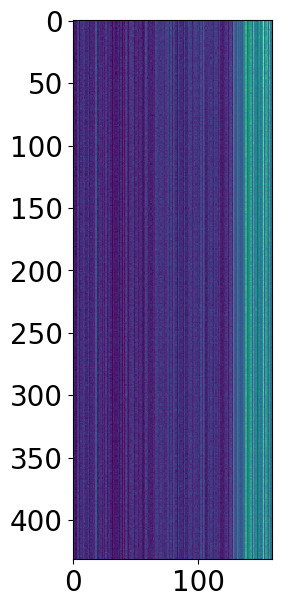

In [200]:
hs_for_gain = all_saved_states['hs'][:,:,:,:]
plt.imshow(torch.mean((hs_for_gain>0)*(1-hs_for_gain**2), dim=(1,2)));

In [42]:
import numpy as np
import os
import pickle
from scipy.stats import binom
from scipy.signal import convolve
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import statsmodels.formula.api as smf
import itertools
import statsmodels.api as sm
from analysis import convert_pvalue_to_asterisks
plt.rc('font', size=15) 
from utils import create_colormap

def obj_to_ft_conj(obj, task_mdprl):
    F1 = task_mdprl.index_shp[obj]
    F2 = task_mdprl.index_pttrn[obj]
    F3 = task_mdprl.index_clr[obj]

    C1 = task_mdprl.index_pttrnclr[obj]
    C2 = task_mdprl.index_shpclr[obj]
    C3 = task_mdprl.index_shppttrn[obj]

    return np.stack([F1, F2, F3, C1, C2, C3], axis=-1)

def obj_to_value_est(obj, task_mdprl):
    pF1, pF2, pF3, pC1, pC2, pC3, pO = task_mdprl.value_est()

    return pF1[obj], pC1[obj], pO[obj]


def credit_assignment(all_saved_states, task_mdprl):
    # find chosen feedback, unchosen feedback
    # stimuli torch.Size([432, 1, 92, 2])
    # reward_probs torch.Size([432, 1, 92, 2])
    # choices torch.Size([432, 1, 92])
    # rewards torch.Size([432, 1, 92])
    # choose_better torch.Size([432, 1, 92])

    num_trials = all_saved_states['rewards'].shape[0]
    num_trials_to_fit = np.arange(0, 150-1)
    num_subj = all_saved_states['rewards'].shape[2]
    all_Xs = []
    all_Ys = []

    for idx_subj in range(num_subj):
        
        stims_pre = all_saved_states['stimuli'][num_trials_to_fit,0,idx_subj,:] # ntrials X 2
        stims_post = all_saved_states['stimuli'][num_trials_to_fit+1,0,idx_subj,:] # ntrials X 2
        stims_pre_chosen = all_saved_states['choices'][num_trials_to_fit,0,idx_subj] # ntrials
        
        choices = all_saved_states['choices'][num_trials_to_fit+1,0,idx_subj]==stims_post[:,1]
        rwd_pre = 2*all_saved_states['rewards'][num_trials_to_fit,0,idx_subj]-1 # ntrials
        
        stimsFCO_pre_chosen = obj_to_ft_conj(stims_pre_chosen, task_mdprl) # ntrials X 7
        stimsFCO_post = obj_to_ft_conj(stims_post, task_mdprl) # ntrials X 2 X 7
        
        
        # predictors are inf dim R chosen, inf dim C chosen, noninf dim R chosen, noninf dim C chosen, 
        subj_Xs = np.concatenate([rwd_pre[:,None]*(stimsFCO_pre_chosen==stimsFCO_post[:,1,:])-
                                  rwd_pre[:,None]*(stimsFCO_pre_chosen==stimsFCO_post[:,0,:]),\
                                  1.0*(stimsFCO_pre_chosen==stimsFCO_post[:,1,:])-
                                  1.0*(stimsFCO_pre_chosen==stimsFCO_post[:,0,:])], axis=-1)
        
        all_Xs.append(subj_Xs)
        all_Ys.append(choices)

    all_Xs = np.concatenate(all_Xs, axis=0)
    all_Ys = np.concatenate(all_Ys, axis=0)[:,None]
    
    var_names = ['F0', 'F1', 'F2', 'C0', 'C1', 'C2']
    rw_ch = ['R', 'C']

    all_var_names = ['_'.join([s, 'R']) for s in var_names] + ['_'.join([s, 'C']) for s in var_names]

    all_data = pd.DataFrame(np.concatenate([all_Xs, all_Ys], axis=1), columns=[*all_var_names, 'choice'])

    mdl = smf.glm('choice~'+'+'.join(all_var_names), data=all_data, family=sm.families.Binomial())
    mdlf = mdl.fit()
    print(mdlf.summary())
    all_coeffs = mdlf.params[1:]
    all_ses = mdlf.bse[1:]
    all_ps = mdlf.pvalues[1:]

    all_xlabels = var_names

    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches((10, 5))
    
    bar_rw = axes[0].bar(x=np.arange(1,len(var_names)+1), \
                height=all_coeffs[:len(var_names)], \
                yerr=all_ses[:len(var_names)], \
                color=mpl.colormaps['tab10'](np.arange(0,7)), 
                capsize=5)
    bar_ch = axes[1].bar(x=np.arange(1,len(var_names)+1), \
                height=all_coeffs[len(var_names):], \
                yerr=all_ses[len(var_names):], \
                color=mpl.colormaps['tab10'](np.arange(0,7)), 
                capsize=5)
    axes[0].set_ylabel('Regression weights')
    axes[0].set_xlabel('Reward')
    axes[1].set_xlabel('Choice')
    axes[0].set_ylim([-0.15, 0.35])
    axes[1].set_ylim([-0.15, 0.35])
    axes[0].set_xticks(np.arange(1, len(var_names)+1), labels=all_xlabels)
    axes[1].set_xticks(np.arange(1, len(var_names)+1), labels=all_xlabels)
    for i in range(6):
        axes[0].text(i+1, all_coeffs[i]+all_ses[i]+0.01, convert_pvalue_to_asterisks(all_ps[i]), 
                     verticalalignment='center', horizontalalignment='center')
        
    for i in range(6):
        axes[1].text(i+1, all_coeffs[i+6]+all_ses[i+6]+0.01, convert_pvalue_to_asterisks(all_ps[i]), 
                     verticalalignment='center', horizontalalignment='center')
    plt.tight_layout()
    # plt.savefig(os.path.join(figure_data_dir, f"credit_assignment_{num_block}.pdf"))
    plt.show()
    # plt.close()
    return

def steady_state_choice_analysis(all_saved_states, task_mdprl):
    num_trials = all_saved_states['rewards'].shape[0]
    num_trials_to_fit = np.arange(282, num_trials)
    num_subj = all_saved_states['rewards'].shape[2]

    all_Xs = []
    all_Ys = []

    for idx_subj in range(num_subj):

        stims = all_saved_states['stimuli'][num_trials_to_fit,0,idx_subj,:] # ntrials X 2
        pF1, pC1, pO = obj_to_value_est(stims, task_mdprl) # ntrials X 2 for each
        choices = all_saved_states['choices'][num_trials_to_fit,0,idx_subj]==stims[:,1] # ntrials

        all_Xs.append(np.stack([np.log(pF1[:,1]/pF1[:,0]), 
                                np.log(pC1[:,1]/pC1[:,0]),
                                np.log(pO[:,1]/pO[:,0]),], axis=1))
        all_Ys.append(choices)
        
    all_Xs = np.concatenate(all_Xs, 0)
    all_Ys = np.concatenate(all_Ys, 0)[:, None]
    

    all_data = pd.DataFrame(np.concatenate([all_Xs, all_Ys], axis=1), columns=['pFinf', 'pCinf', 'pO', 'choice']).fillna(0)
    data_group_by_F_m = all_data.groupby('pFinf').mean().apply(np.array).loc[:,'choice']
    data_group_by_F_se = all_data.groupby('pFinf').sem().apply(np.array).loc[:,'choice']
    data_group_by_C_m = all_data.groupby('pCinf').mean().apply(np.array).loc[:,'choice']
    data_group_by_C_se = all_data.groupby('pCinf').sem().apply(np.array).loc[:,'choice']

    fig, axes = plt.subplots()
    fig.set_size_inches((7, 5))
    axes.errorbar(data_group_by_F_m.index.values, 
                 data_group_by_F_m.values, 
                 data_group_by_F_se.values,
                 c=mpl.colormaps['tab10']([0]),
                 ls='', marker='o', mfc='white')
    axes.errorbar(data_group_by_C_m.index.values, 
                 data_group_by_C_m.values, 
                 data_group_by_C_se.values,
                 c=mpl.colormaps['tab10']([3]),
                 ls='', marker='o', mfc='white')
    

    mdl = smf.glm('choice~pFinf+pCinf+pO', all_data, missing='drop', family=sm.families.Binomial())
    mdlf = mdl.fit()
    print(mdlf.summary())
    all_coeffs = mdlf.params[1:]
    all_ses = mdlf.bse[1:]
    all_ps = mdlf.pvalues[1:]

    all_coeffs = np.stack(all_coeffs)
    all_ses = np.stack(all_ses)
    all_ps = np.stack(all_ps)

    var_names = ['F0', 'C0', 'O']
    
    xs = np.linspace(-1., 1., 100)
    
    axes.plot(xs, 1/(1+np.exp(-all_coeffs[0]*xs)), color=mpl.colormaps['tab10']([0]), label='F0')
    axes.plot(xs, 1/(1+np.exp(-all_coeffs[1]*xs)), color=mpl.colormaps['tab10']([3]), label='C0')
    axes.legend()
    
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    axin = inset_axes(axes, width="35%", height="35%", loc=4, borderpad=1)
    axin.bar(np.arange(1, len(var_names)+1), all_coeffs, color=mpl.colormaps['tab10']([0, 3, 7]))
    axin.errorbar(np.arange(1, len(var_names)+1), all_coeffs, all_ses, linestyle="", color='k')
    axin.text(1, all_coeffs[0]+all_ses[0]+0.05, convert_pvalue_to_asterisks(all_ps[0]), 
            verticalalignment='center', horizontalalignment='center', fontsize=14)
    axin.text(2, all_coeffs[1]+all_ses[1]+0.05, convert_pvalue_to_asterisks(all_ps[1]), 
            verticalalignment='center', horizontalalignment='center', fontsize=14)
    plt.text(3, all_coeffs[2]*np.sign(all_ses[2]+0.1), convert_pvalue_to_asterisks(all_ps[2]), 
            verticalalignment='center', horizontalalignment='center')
    axin.set_ylim([-0.1, 2.5])
    axin.set_xticks(range(1,4), labels=var_names, fontsize=12)
    axin.set_yticks(range(0,3), labels=range(0,3), fontsize=12)
    axin.set_ylabel('Slopes', fontsize=14)
    axes.set_xlabel('Log odd of reward')
    axes.set_ylabel('Choice probability')
#     plt.tight_layout()
    # plt.savefig(os.path.join(figure_data_dir, "choice_curves_slope.pdf"))
    plt.show()
    # plt.close()
    return


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 choice   No. Observations:                13800
Model:                            GLM   Df Residuals:                    13796
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7788.2
Date:                Sun, 30 Apr 2023   Deviance:                       15576.
Time:                        01:47:23   Pearson chi2:                 1.36e+04
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2270
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0214      0.020     -1.097      0.2

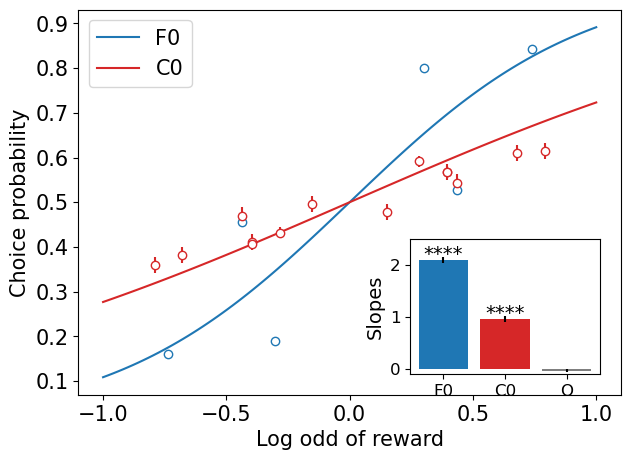

In [43]:
steady_state_choice_analysis(all_saved_states, task_mdprl)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 choice   No. Observations:                13708
Model:                            GLM   Df Residuals:                    13695
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9328.7
Date:                Sun, 30 Apr 2023   Deviance:                       18657.
Time:                        01:48:11   Pearson chi2:                 1.37e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.02488
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0071      0.017     -0.409      0.6

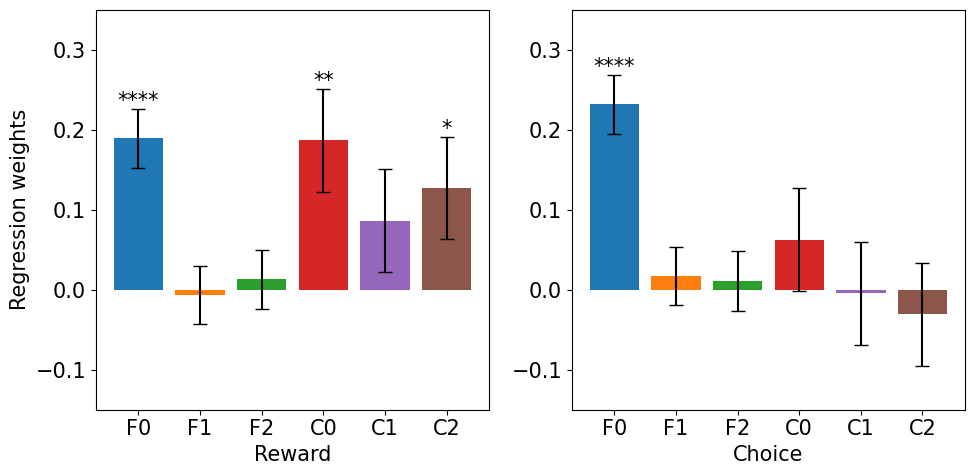

In [47]:
credit_assignment(all_saved_states, task_mdprl)

In [129]:
selectivity = np.empty((27, args['hidden_size']*args['num_areas']))
for i in range(27):
    selectivity[i] = all_saved_states['hs'].mean(1)[all_saved_states['choices'].squeeze()==i,:].mean(0)
    

[0 0 2 2 2 0]
tensor([0.])
[[[2 2 0 6 6 8]
  [0 0 2 2 2 0]]]
(array([[0.32333333, 0.67666667]]), array([[0.33666667, 0.66333333]]), array([[0.08, 0.92]]))


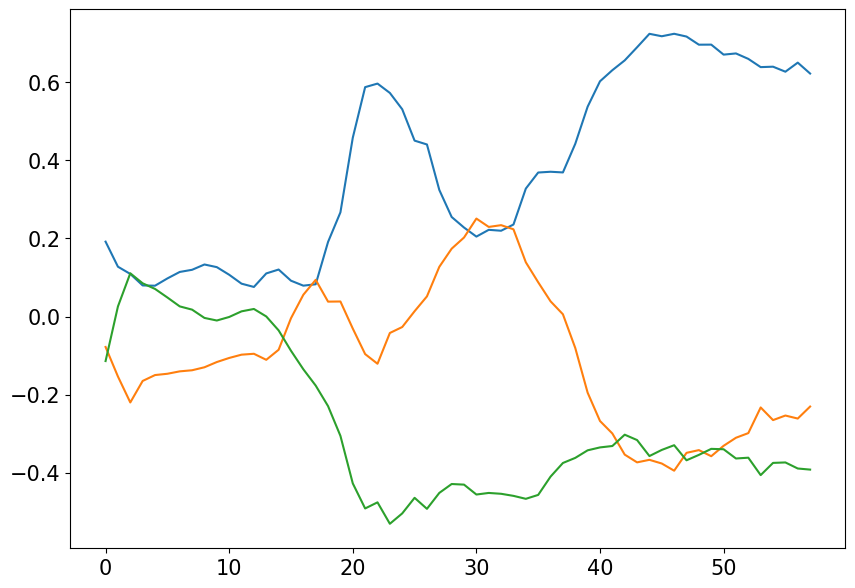

In [50]:
ttt = 250
iii = 11

plt.plot(np.dot((all_saved_states['hs'][ttt,:,iii,input_weight_inds]),\
         dpca_in.marginalized_psth['s'].squeeze().reshape(-1, 3)))
print(obj_to_ft_conj(all_saved_states['choices'][ttt,:,iii], task_mdprl))
print(all_saved_states['rewards'][ttt,:,iii])
print(obj_to_ft_conj(all_saved_states['stimuli'][ttt,:,iii], task_mdprl))
print(obj_to_value_est(all_saved_states['stimuli'][ttt,:,iii], task_mdprl))

In [52]:
dpca_out.marginalized_psth['s'].squeeze().shape

(80, 3)

In [118]:
all_whs = all_saved_states['whs_final'].squeeze()*model.rnn.h2h.mask.reshape(1,1,160,160)-model.rnn.h2h.effective_weight().detach()
all_ff_whs = all_whs[:,:,output_weight_inds][:,:,:,input_weight_inds]
all_fb_whs = all_whs[:,:,input_weight_inds][:,:,:,output_weight_inds]
all_rec_in_whs = all_whs[:,:,input_weight_inds][:,:,:,input_weight_inds]
all_rec_out_whs = all_whs[:,:,output_weight_inds][:,:,:,output_weight_inds]

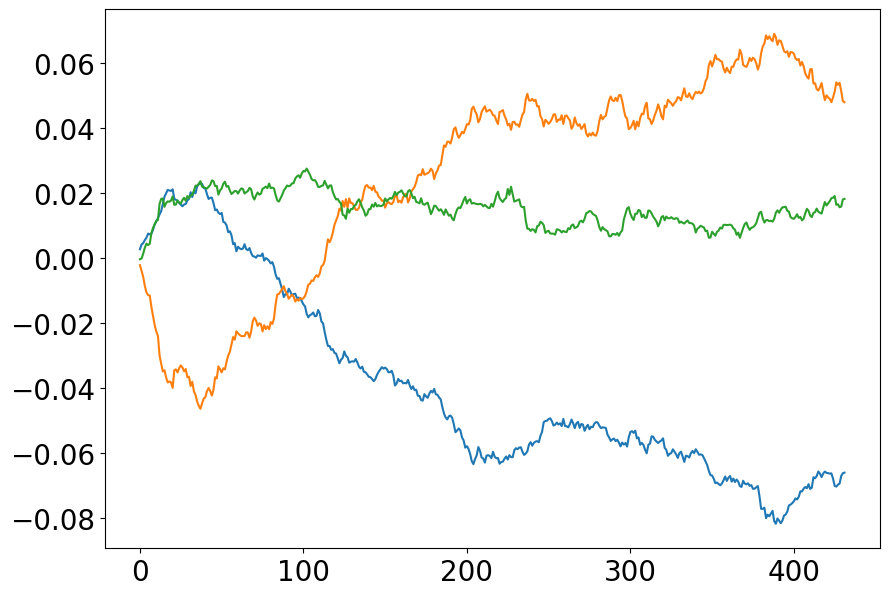

In [249]:
plt.plot(np.dot(
    (all_ff_whs.mean(1)@dpca_in.marginalized_psth['p'].reshape((1, 80, 3))).transpose(1,2),
         dpca_out.marginalized_psth['p'].reshape((80, 3)))[:,:,1])

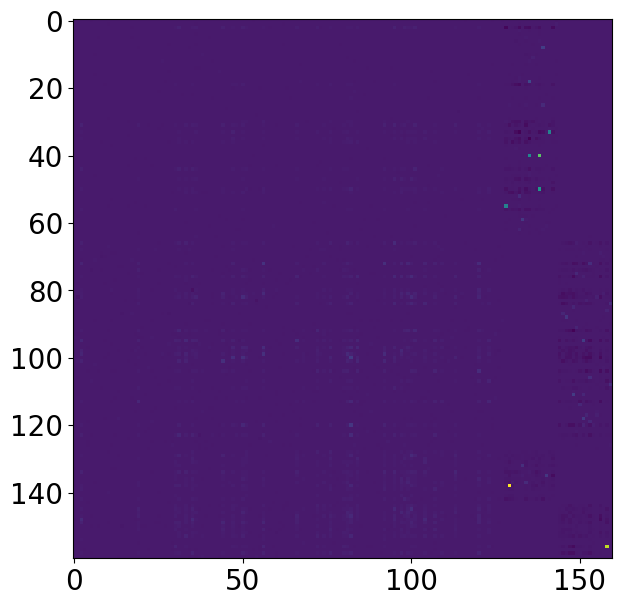

In [132]:
plt.imshow(all_whs[0,42])

In [114]:
task_mdprl.prob_mdprl.mean(1)

array([[[0.66333333, 0.22666667, 0.66333333],
        [0.5       , 0.5       , 0.5       ],
        [0.33666667, 0.77333333, 0.33666667]]])

In [231]:
(all_saved_states['whs_final'][:,0,:][:,:,input_weight_inds][:,:,:,input_weight_inds]@\
dpca_in.marginalized_psth['c'].reshape((1, 1, 80, 3))).mean(1).squeeze().shape

torch.Size([432, 80, 3])

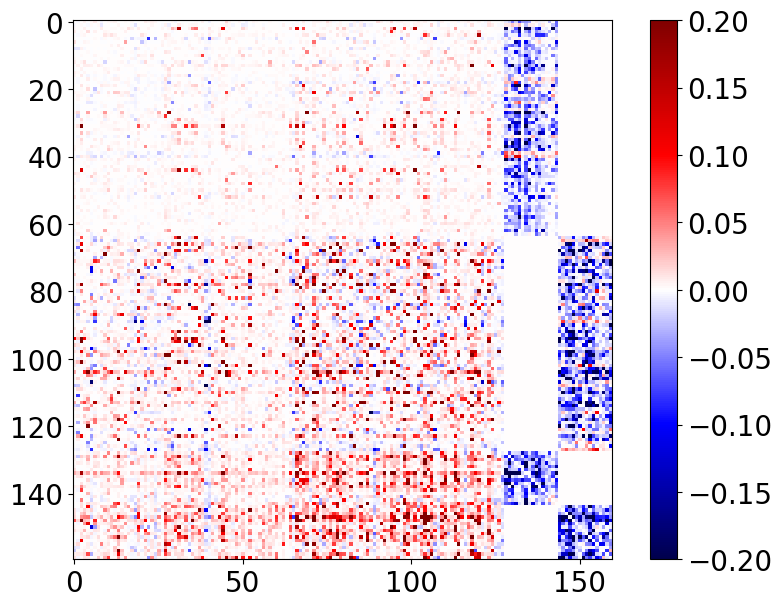

In [110]:
plt.imshow((all_saved_states['whs_final'][431,0].mean(0)-all_saved_states['whs_final'][0,0].mean(0))*model.rnn.h2h.mask, vmax=0.2, vmin=-0.2, cmap='seismic')
plt.colorbar()

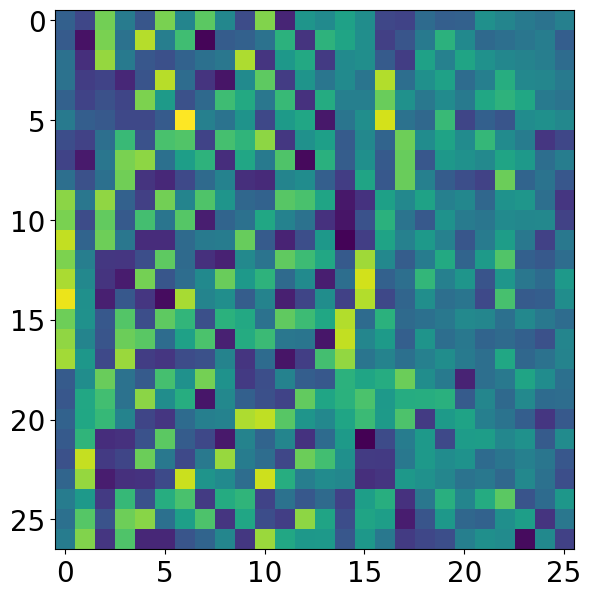

In [62]:
plt.imshow(stims.T@all_dpca_axes)

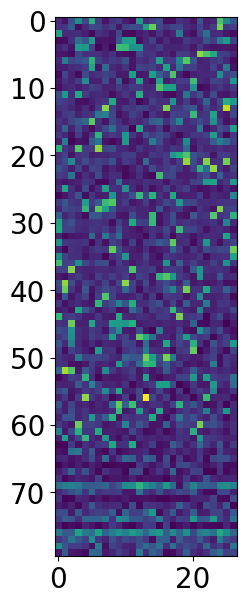

In [63]:
plt.imshow(stims)